# Libraries

In [677]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [678]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import src.edhec_risk_kit as erk
import portfolio_design.src.analysis as an

from scipy import stats
from src import data


ix = pd.IndexSlice

%matplotlib inline

Here's what we want to do:

1. Lookup a symbol representing a financial asset (e.g. SPY)
2. Compute the symbol utility as an equity-indexed annuity (constant growth rate)
    - Annualized return (1 year return with compounding)
3. Compute the risk on monthly or annual returns

# Select the portfolio

Specify the tickers to compare.

In [695]:
tickers = [
  'SOXX',
  'BB.TO',
  'SPY',
  'ICLN',
  'AC.TO',
  'SU.TO',
  'DHR',
  'COST',
  'SHV',
  'IEF',
  'NEAR'
]

In [696]:
mmd_df = (
  data
    .get_monthly_market_data(tickers, interval = '1mo')
)

mr_df = data.compute_monthly_returns_from_mmd(mmd_df)

[*********************100%***********************]  11 of 11 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.9/site-packages/pandas/core/generic.py:4152: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [697]:
r1_df = data.compute_monthly_returns_from_mmd(mmd_df)
r6_df = data.compute_period_returns_from_mmd(mmd_df, periods = 6)
r12_df = data.compute_period_returns_from_mmd(mmd_df, periods = 12)
r24_df = data.compute_period_returns_from_mmd(mmd_df, periods = 24)

In [699]:
(
  r1_df
    .melt(
      ignore_index = False,
      var_name = 'Asset',
      value_name = 'Return'
    )
    .assign(period = '1 Month')
)

,Asset,Return,period
date,,,
1985-01-01,AC.TO,NaN,1 Month
1985-02-01,AC.TO,NaN,1 Month
1985-03-01,AC.TO,NaN,1 Month
1985-04-01,AC.TO,NaN,1 Month
1985-05-01,AC.TO,NaN,1 Month
...,...,...,...
2021-01-01,SU.TO,0.012172,1 Month
2021-02-01,SU.TO,0.181393,1 Month
2021-03-01,SU.TO,0.039573,1 Month


# Review price trends

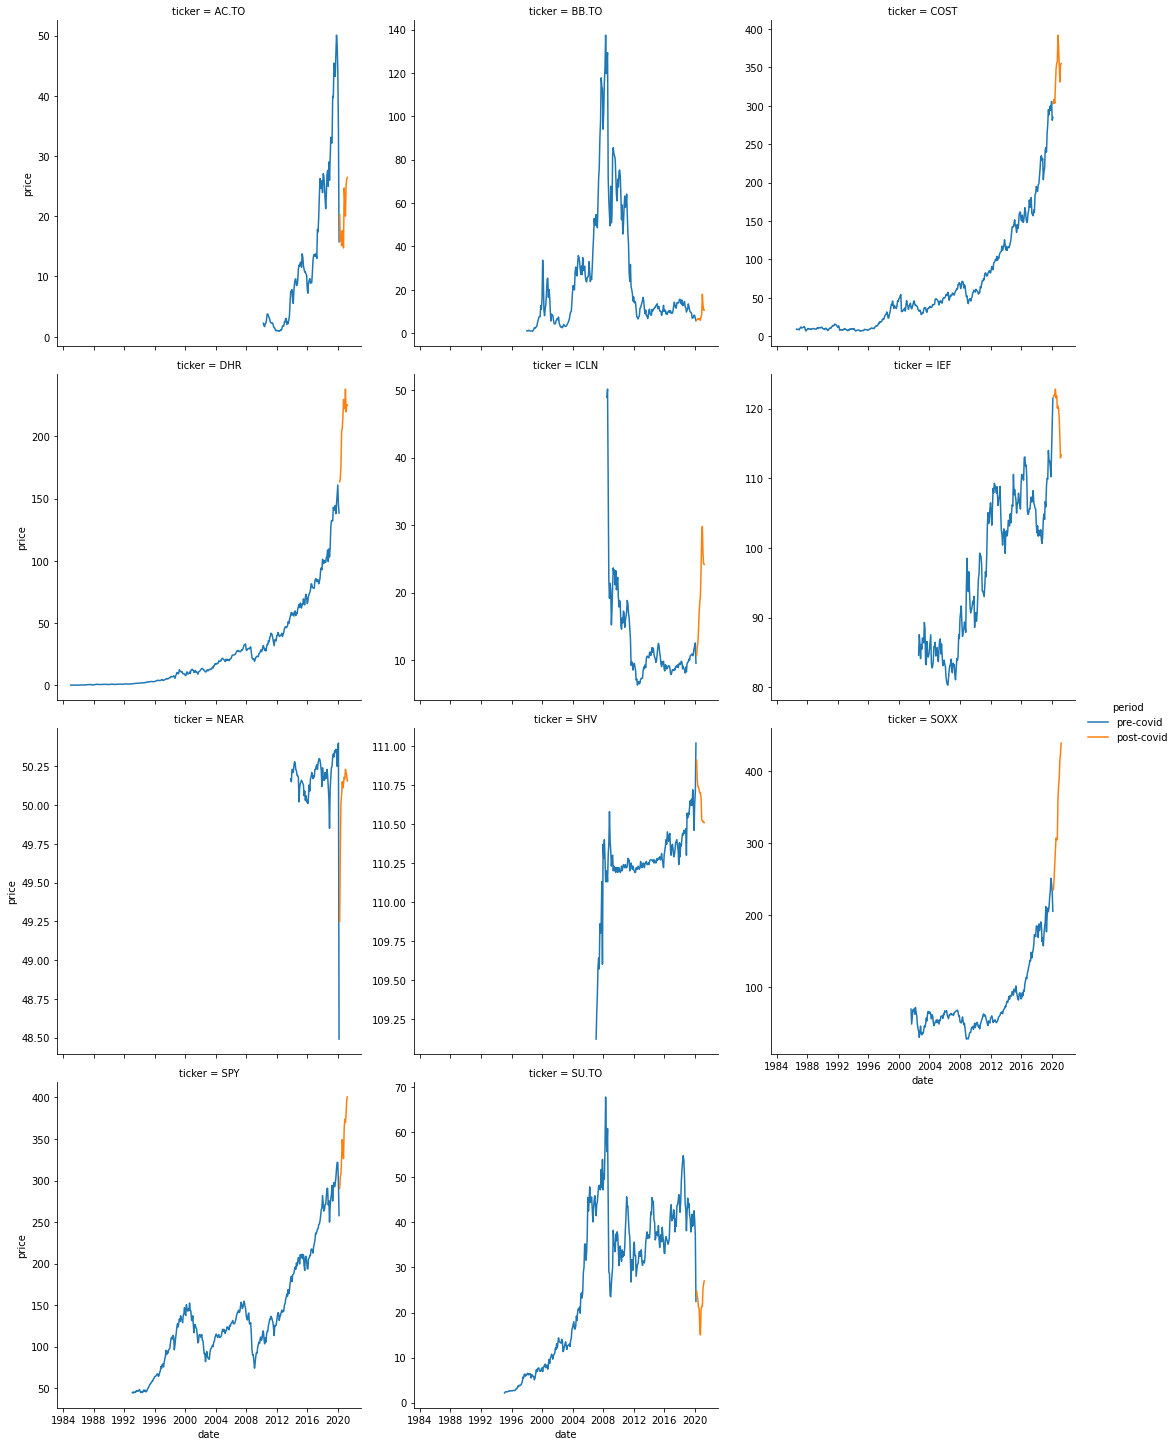

In [683]:
mmd_long_df = (
  mmd_df['close']
    .reset_index()
    .assign(
      period = lambda df: df['date'].apply(
        lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
      )
    )
    .melt(
      id_vars = ['date', 'period'], 
      var_name = 'ticker', 
      value_name = 'price',
    )
)

sns.relplot(
  x = 'date',
  y = 'price',
  kind = 'line',
  col = 'ticker',
  hue = 'period',
  data = mmd_long_df,
  col_wrap = 3,
  facet_kws = {'sharey': False}
);

# Review individual return series and distributions

## Time Series

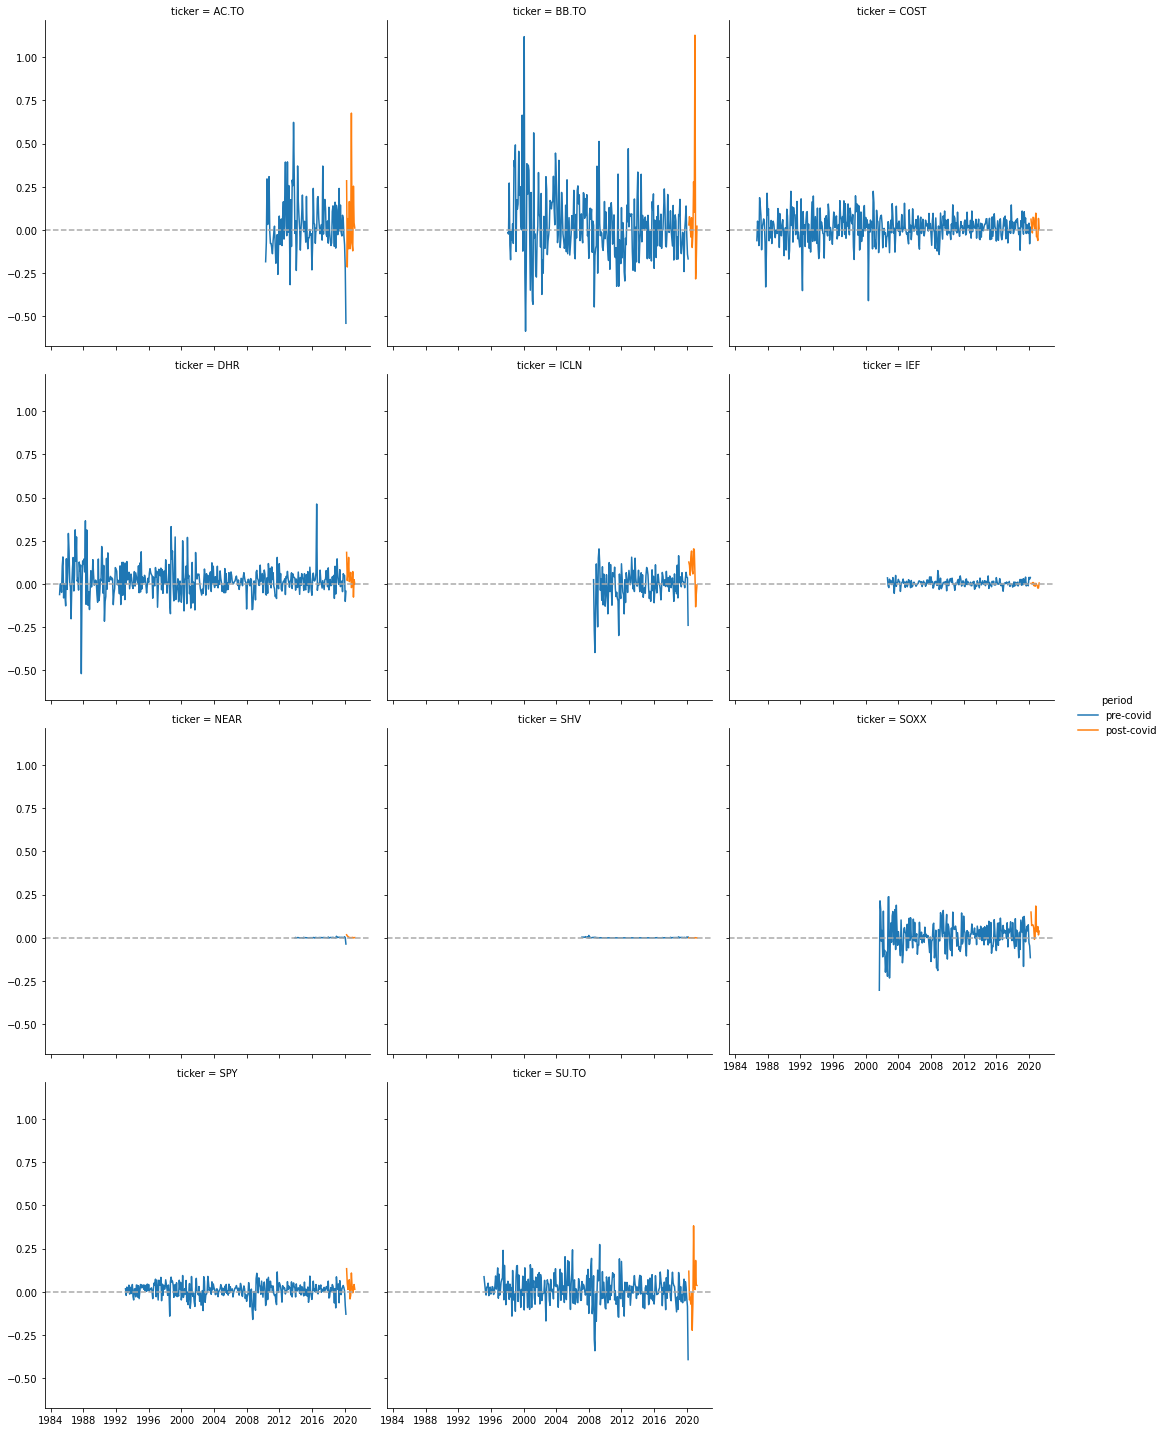

In [684]:
r1_long_df = (
  r1_df
    .reset_index()
    .assign(
      period = lambda df: df['date'].apply(
        lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
      )
    )
    .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
)

f = sns.relplot(
  x = 'date',
  y = 'return',
  kind = 'line',
  col = 'ticker',
  hue = 'period',
  data = r1_long_df,
  col_wrap = 3
);

f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

## Distributions

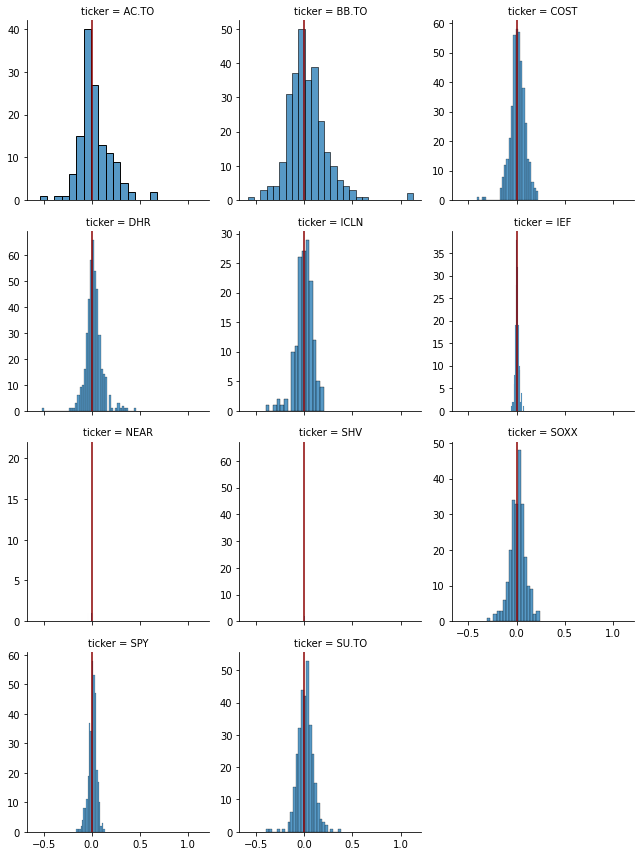

In [685]:
f = sns.FacetGrid(
  data = r1_long_df,
  col = 'ticker',
  #hue = 'period',
  sharey = False,
  col_wrap = 3
)

f.map(sns.histplot, 'return');
f.map(plt.axvline, x=0, color = 'darkred')

# Period returns

## 1 Month

In [629]:
r1_df.reset_index().melt(id_vars = ['date']).query('~value.isnull()').groupby('variable').min().sort_values('date')

,date,value
variable,,
DHR,1985-02-01,-0.519685
COST,1986-09-01,-0.409248
SPY,1993-03-01,-0.160355
SU.TO,1995-03-01,-0.392809
BB.TO,1998-02-01,-0.586184
SOXX,2001-09-01,-0.303457
IEF,2002-09-01,-0.054738
SHV,2007-03-01,-0.001248
ICLN,2008-08-01,-0.397204


In [630]:
r1_df.describe().T.sort_values('mean', ascending = False).assign(years = lambda df: df['count'] / 12).drop(columns = 'count').style.bar(subset = ['mean', 'std'])

,mean,std,min,25%,50%,75%,max,years
AC.TO,0.032435,0.168353,-0.540146,-0.074795,-0.004300,0.126124,0.676850,11.000000
BB.TO,0.028071,0.204058,-0.586184,-0.093576,0.007098,0.120763,1.127962,23.250000
DHR,0.021065,0.085398,-0.519685,-0.022983,0.016807,0.060177,0.462736,36.250000
SU.TO,0.013261,0.084977,-0.392809,-0.037183,0.013942,0.060508,0.381903,26.166667
COST,0.012780,0.078881,-0.409248,-0.028981,0.012747,0.059543,0.224138,34.666667
SOXX,0.011781,0.082391,-0.303457,-0.039464,0.020021,0.064024,0.238356,19.666667
SPY,0.008967,0.042763,-0.160355,-0.015080,0.013879,0.036678,0.133611,28.166667
IEF,0.003968,0.018362,-0.054738,-0.006260,0.002524,0.013586,0.077309,18.666667
ICLN,0.001892,0.093434,-0.397204,-0.044308,0.009602,0.057117,0.202965,12.750000
NEAR,0.001239,0.004784,-0.035945,0.000479,0.001199,0.002055,0.017612,7.416667


In [631]:
erk.annualize_rets(r1_df, 12).rename('Annualized Return').sort_values(ascending=False)

DHR      0.229775
COST     0.114894
SU.TO    0.085877
SPY      0.077395
BB.TO    0.071722
AC.TO    0.070741
SOXX     0.055396
IEF      0.023666
SHV      0.003749
NEAR     0.003011
ICLN    -0.011669
Name: Annualized Return, dtype: float64

In [632]:
erk.annualize_rets(r1_df, 24).rename('Annualized Return').sort_values(ascending=False)

DHR      0.512346
COST     0.242988
SU.TO    0.179130
SPY      0.160781
BB.TO    0.148589
AC.TO    0.146486
SOXX     0.113861
IEF      0.047891
SHV      0.007513
NEAR     0.006030
ICLN    -0.023202
Name: Annualized Return, dtype: float64

In [633]:
r1_df['2010':].describe().T.sort_values('mean', ascending = False).assign(years = lambda df: df['count'] / 12).drop(columns = 'count').style.bar(subset = ['mean', 'std'])

,mean,std,min,25%,50%,75%,max,years
AC.TO,0.032435,0.168353,-0.540146,-0.074795,-0.004300,0.126124,0.676850,11.000000
DHR,0.020353,0.064985,-0.101262,-0.020413,0.016555,0.054477,0.462736,11.333333
SOXX,0.018772,0.062406,-0.165627,-0.023887,0.028067,0.064024,0.184398,11.333333
COST,0.016077,0.047480,-0.117112,-0.017369,0.014574,0.050666,0.145569,11.333333
SPY,0.011815,0.040792,-0.129987,-0.008186,0.014557,0.032829,0.133611,11.333333
ICLN,0.005937,0.080598,-0.298790,-0.043016,0.008241,0.056202,0.202965,11.333333
IEF,0.003647,0.016650,-0.042329,-0.006331,0.000870,0.013222,0.046511,11.333333
SU.TO,0.003471,0.083719,-0.392809,-0.042901,-0.000183,0.052115,0.381903,11.333333
NEAR,0.001239,0.004784,-0.035945,0.000479,0.001199,0.002055,0.017612,7.416667
BB.TO,0.000567,0.170900,-0.325758,-0.098863,-0.001909,0.085641,1.127962,11.333333


In [634]:
(.033+.020+.018)/3

0.02366666666666667

In [635]:
erk.annualize_rets(r1_df['2010':], 24).rename('Annualized Return').sort_values(ascending=False)

DHR      0.551074
AC.TO    0.549991
SOXX     0.493379
COST     0.428729
SPY      0.299925
IEF      0.087742
ICLN     0.064859
NEAR     0.019461
SHV      0.010945
SU.TO   -0.002979
BB.TO   -0.254770
Name: Annualized Return, dtype: float64

In [636]:
(0.57+ 0.540+0.483)/3

0.531

In [637]:
(0.57+ 0.540+0.483+0.426)/4

0.50475

In [638]:
erk.annualize_vol(r1_df['2015':], 12).rename('Annualized Return').sort_values(ascending=False)

BB.TO    0.604460
AC.TO    0.533611
SU.TO    0.320055
ICLN     0.266685
DHR      0.254864
SOXX     0.225748
COST     0.174093
SPY      0.149139
IEF      0.056214
NEAR     0.017831
SHV      0.004187
Name: Annualized Return, dtype: float64

## 6 Month

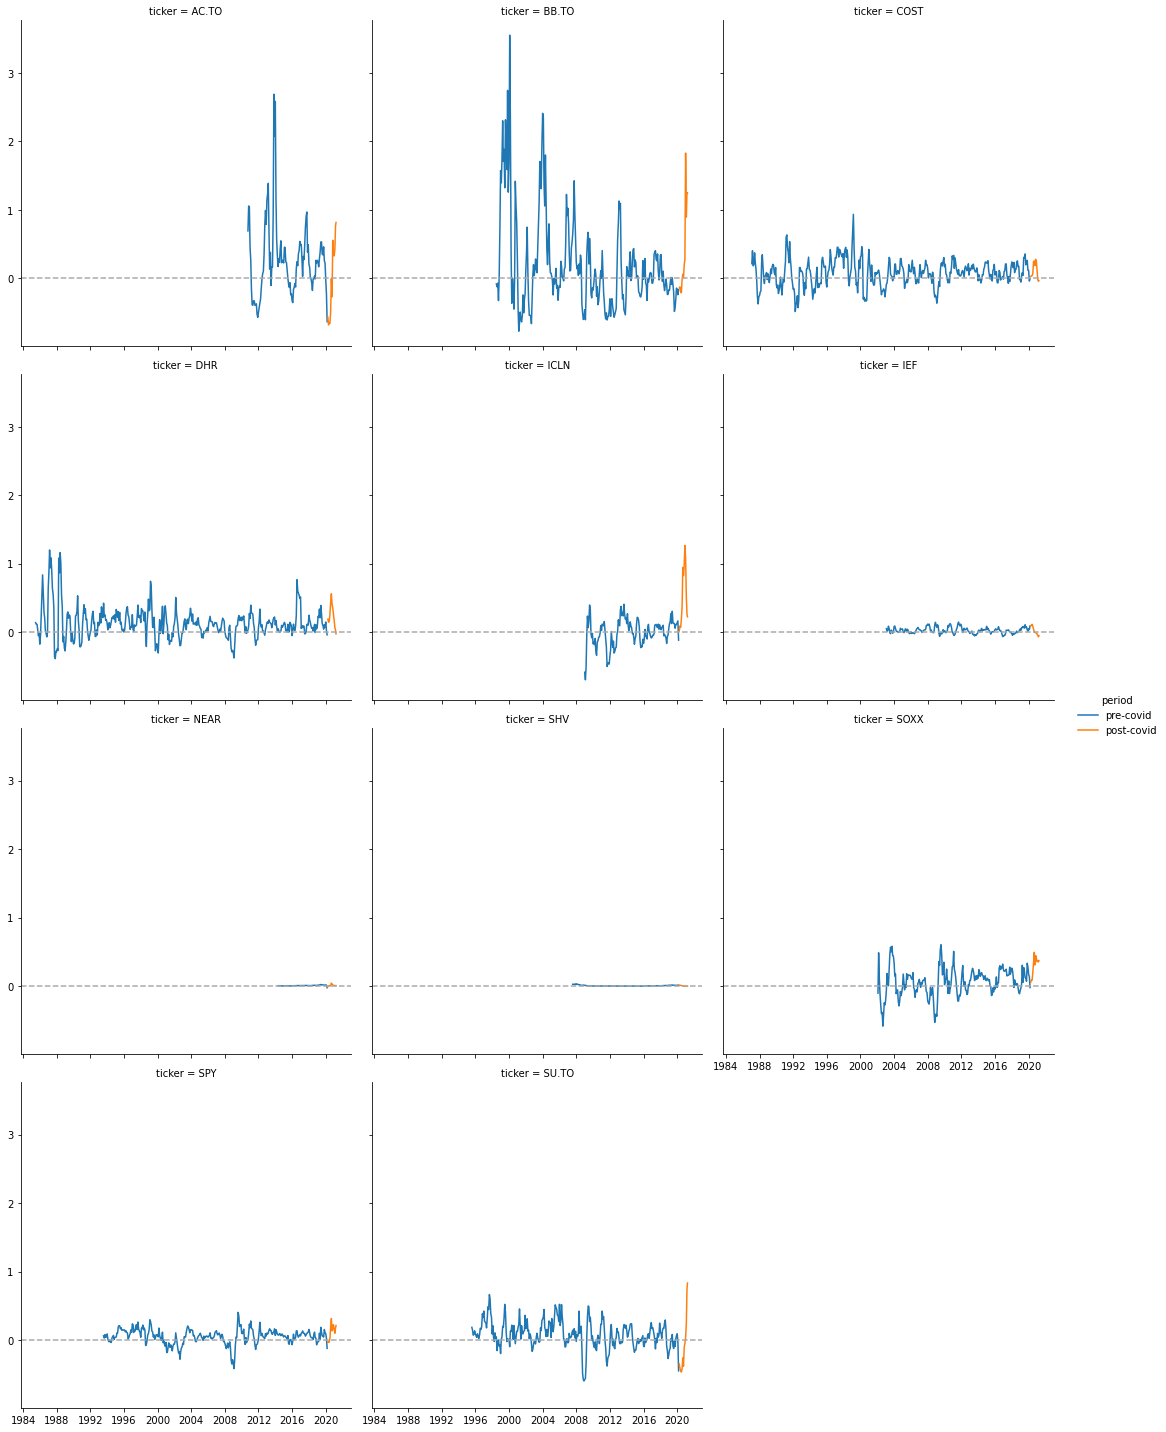

In [639]:
r6_long_df = (
  r6_df
    .reset_index()
    .assign(
      period = lambda df: df['date'].apply(
        lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
      )
    )
    .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
)

f = sns.relplot(
  x = 'date',
  y = 'return',
  kind = 'line',
  col = 'ticker',
  hue = 'period',
  data = r6_long_df,
  col_wrap = 3
);

f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

In [640]:
r6_df.rolling(6).mean().loc['2015':].describe()

,AC.TO,BB.TO,COST,DHR,ICLN,IEF,NEAR,SHV,SOXX,SPY,SU.TO
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.135492,0.018327,0.106765,0.158562,0.092557,0.021538,0.007838,0.004663,0.134044,0.060984,-0.020749
std,0.293863,0.222026,0.070889,0.128737,0.228910,0.034264,0.005144,0.004466,0.117066,0.050613,0.144280
min,-0.613688,-0.296693,0.003598,0.030045,-0.173052,-0.046014,-0.003316,-0.000060,-0.073557,-0.029845,-0.426288
25%,-0.042294,-0.142217,0.039674,0.065578,-0.031640,-0.003856,0.003806,0.000759,0.033679,0.025706,-0.072444
50%,0.194504,-0.035296,0.107174,0.100839,0.053119,0.019091,0.007122,0.002752,0.142937,0.066348,-0.009321
75%,0.356909,0.130632,0.172335,0.214632,0.109062,0.046671,0.010031,0.009136,0.203566,0.088744,0.079695
max,0.661202,0.947631,0.270375,0.580355,0.933785,0.087081,0.018581,0.012578,0.395518,0.200451,0.279970


In [641]:
r6_df.rolling(6).apply(erk.semideviation).loc['2015':].describe()

,AC.TO,BB.TO,COST,DHR,ICLN,IEF,NEAR,SHV,SOXX,SPY,SU.TO
count,43.000000,66.000000,50.000000,26.000000,51.000000,41.000000,13.000000,18.000000,37.000000,30.000000,61.000000
mean,0.093732,0.059357,0.009203,0.000391,0.027940,0.009477,0.004028,0.000140,0.019526,0.019200,0.057586
std,0.087143,0.044693,0.008462,0.000818,0.020006,0.006673,0.004739,0.000140,0.022286,0.015544,0.048706
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025987,0.027079,0.000000,0.000000,0.009932,0.001640,0.000000,0.000043,0.000000,0.005063,0.028929
50%,0.069366,0.050292,0.011108,0.000000,0.033044,0.011469,0.000000,0.000100,0.012501,0.019730,0.045568
75%,0.120454,0.088713,0.017959,0.000000,0.046075,0.014050,0.010037,0.000169,0.034724,0.030104,0.067769
max,0.256217,0.168898,0.021926,0.002036,0.058544,0.022343,0.010037,0.000367,0.067100,0.045715,0.185175


## 12 Month

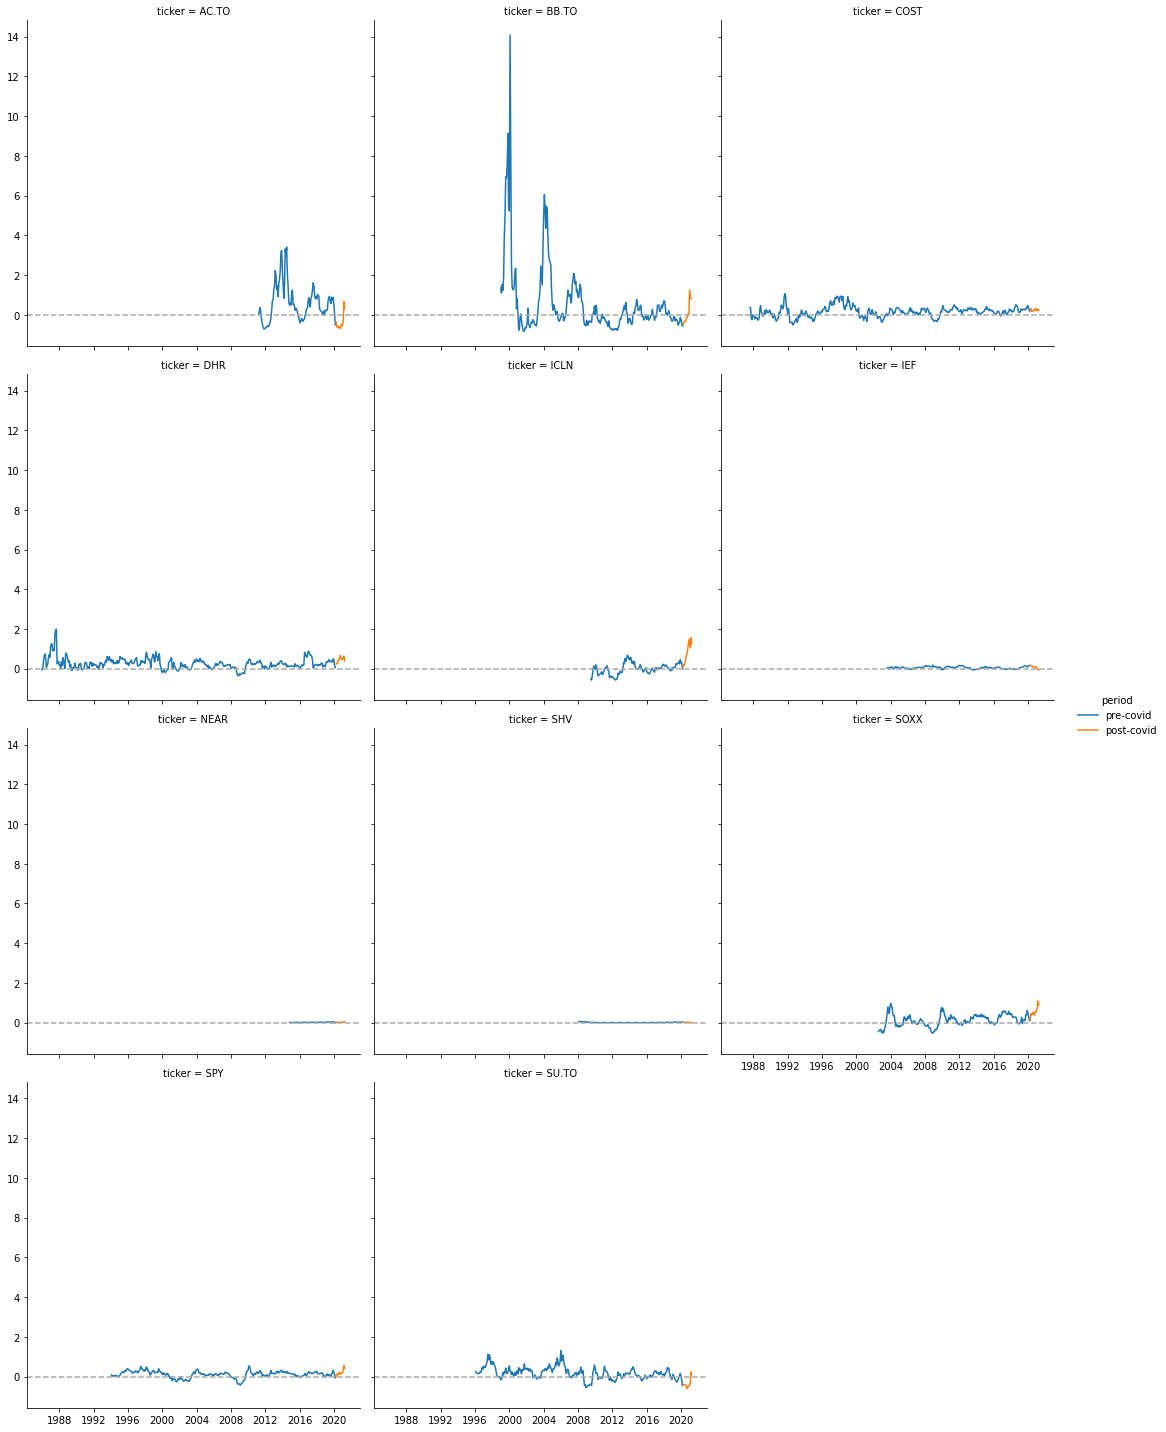

In [686]:
r12_long_df = (
  r12_df
    .reset_index()
    .assign(
      period = lambda df: df['date'].apply(
        lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
      )
    )
    .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
)

f = sns.relplot(
  x = 'date',
  y = 'return',
  kind = 'line',
  col = 'ticker',
  hue = 'period',
  data = r12_long_df,
  col_wrap = 3
);

f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

In [643]:
r12_df.rolling(12).mean().loc['2015':].describe()

,AC.TO,BB.TO,COST,DHR,ICLN,IEF,NEAR,SHV,SOXX,SPY,SU.TO
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,67.000000,76.000000,76.000000,76.000000,76.000000
mean,0.409627,0.009127,0.202952,0.298396,0.100859,0.044431,0.015400,0.008841,0.259647,0.117321,0.002915
std,0.500394,0.235653,0.076001,0.151789,0.206471,0.047424,0.006584,0.008461,0.157002,0.053641,0.178218
min,-0.542128,-0.382507,0.065029,0.120746,-0.140435,-0.018875,0.006040,0.000112,-0.018305,0.012642,-0.453129
25%,0.061287,-0.151879,0.140589,0.172060,-0.023649,-0.005584,0.010165,0.001066,0.120661,0.082287,-0.078970
50%,0.391861,-0.021715,0.230020,0.276879,0.060267,0.043603,0.014790,0.005107,0.263928,0.115484,0.011491
75%,0.678772,0.204099,0.270055,0.375076,0.153891,0.065109,0.019989,0.016834,0.387736,0.167216,0.155759
max,1.597038,0.440735,0.305199,0.698712,0.896931,0.135346,0.029961,0.023727,0.580126,0.211559,0.225700


In [644]:
r12_df.rolling(12).apply(erk.semideviation).loc['2015':].describe()

,AC.TO,BB.TO,COST,DHR,ICLN,IEF,NEAR,SHV,SOXX,SPY,SU.TO
count,48.000000,73.000000,21.000000,0.0,67.000000,40.000000,12.0,21.000000,40.000000,42.000000,59.000000
mean,0.070343,0.096722,0.006069,NaN,0.038326,0.008654,0.0,0.000031,0.018040,0.009673,0.070880
std,0.050172,0.045365,0.010274,NaN,0.031246,0.005714,0.0,0.000030,0.012996,0.010791,0.048167
min,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.085742,0.000000,NaN,0.002025,0.006014,0.0,0.000000,0.003190,0.000000,0.036986
50%,0.094878,0.096772,0.002650,NaN,0.040164,0.008654,0.0,0.000059,0.018932,0.011054,0.062901
75%,0.110970,0.122397,0.002650,NaN,0.061225,0.010978,0.0,0.000059,0.031576,0.021769,0.088936
max,0.140502,0.212651,0.028664,NaN,0.089558,0.029013,0.0,0.000059,0.037750,0.026764,0.180588


## 24 Month

In [704]:
r24_df.loc['2010-10-01':, 'SPY'].mean()

0.3086237280087726

In [706]:
erk.cvar_historic(r24_df.loc['2010-10-01':, 'SPY'])

-0.0945670513112489

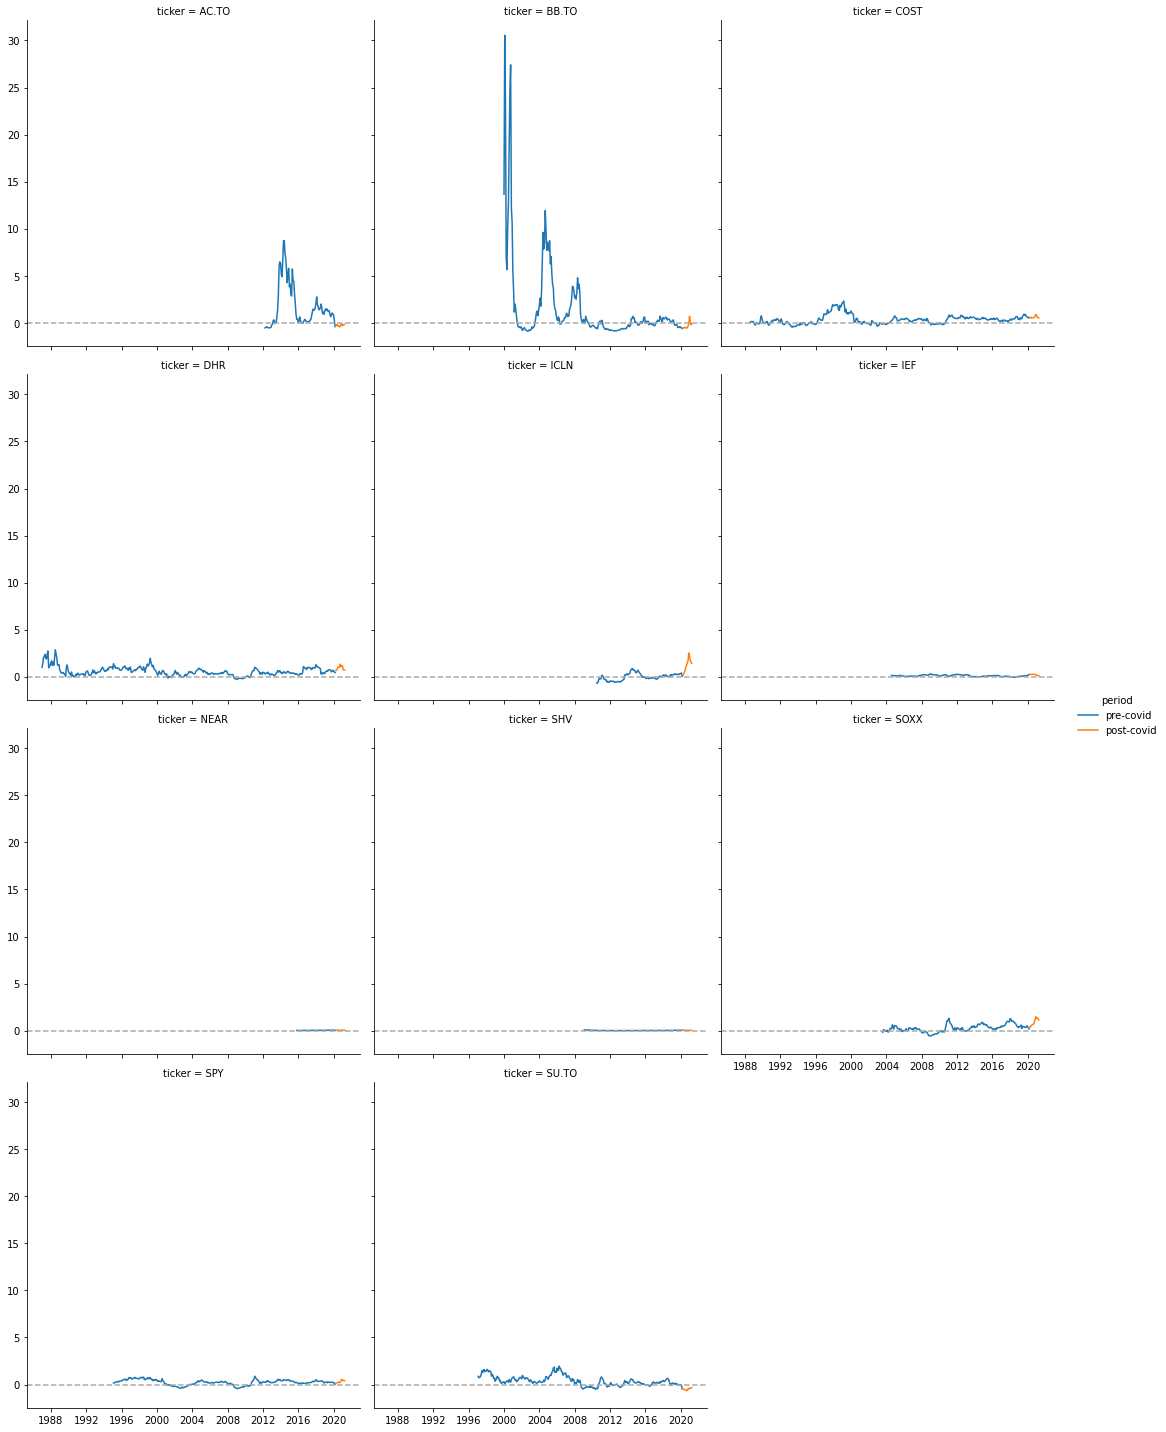

In [687]:
r24_long_df = (
  r24_df
    .reset_index()
    .assign(
      period = lambda df: df['date'].apply(
        lambda d: 'pre-covid' if d <= pd.to_datetime('2020-03-01') else 'post-covid'
      )
    )
    .melt(id_vars = ['date', 'period'], var_name = 'ticker', value_name = 'return')
)

f = sns.relplot(
  x = 'date',
  y = 'return',
  kind = 'line',
  col = 'ticker',
  hue = 'period',
  data = r24_long_df,
  col_wrap = 3
);

f.map(plt.axhline, y = 0, ls = '--', color = 'darkgrey');

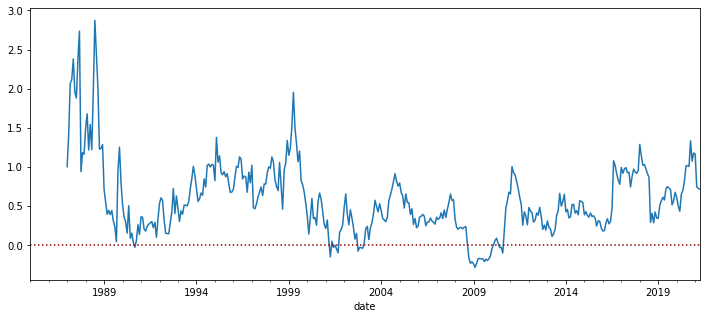

In [688]:
r24_long_df.query('ticker == "DHR"').set_index('date')['return'].plot(figsize = (12, 5))
plt.axhline(0, color = 'darkred', ls = ':')

In [ ]:
erk.var_historic(r24_df.drop(columns = 'VGAB.TO').dropna()).sort_values(ascending = False)

In [ ]:
r24_df.rolling(12).apply(erk.semideviation).loc['2015':].dropna().describe()

# 4. Review rolling annualized returns

## 6-Month Rolling

,date,period,ticker,return
0,1985-01-01,pre-covid,AC.TO,0.000000
1,1985-02-01,pre-covid,AC.TO,0.000000
2,1985-03-01,pre-covid,AC.TO,0.000000
3,1985-04-01,pre-covid,AC.TO,0.000000
4,1985-05-01,pre-covid,AC.TO,0.000000
...,...,...,...,...
4355,2020-12-01,post-covid,VGAB.TO,-0.006926
4356,2021-01-01,post-covid,VGAB.TO,-0.039467
4357,2021-02-01,post-covid,VGAB.TO,-0.056954
4358,2021-03-01,post-covid,VGAB.TO,-0.075116


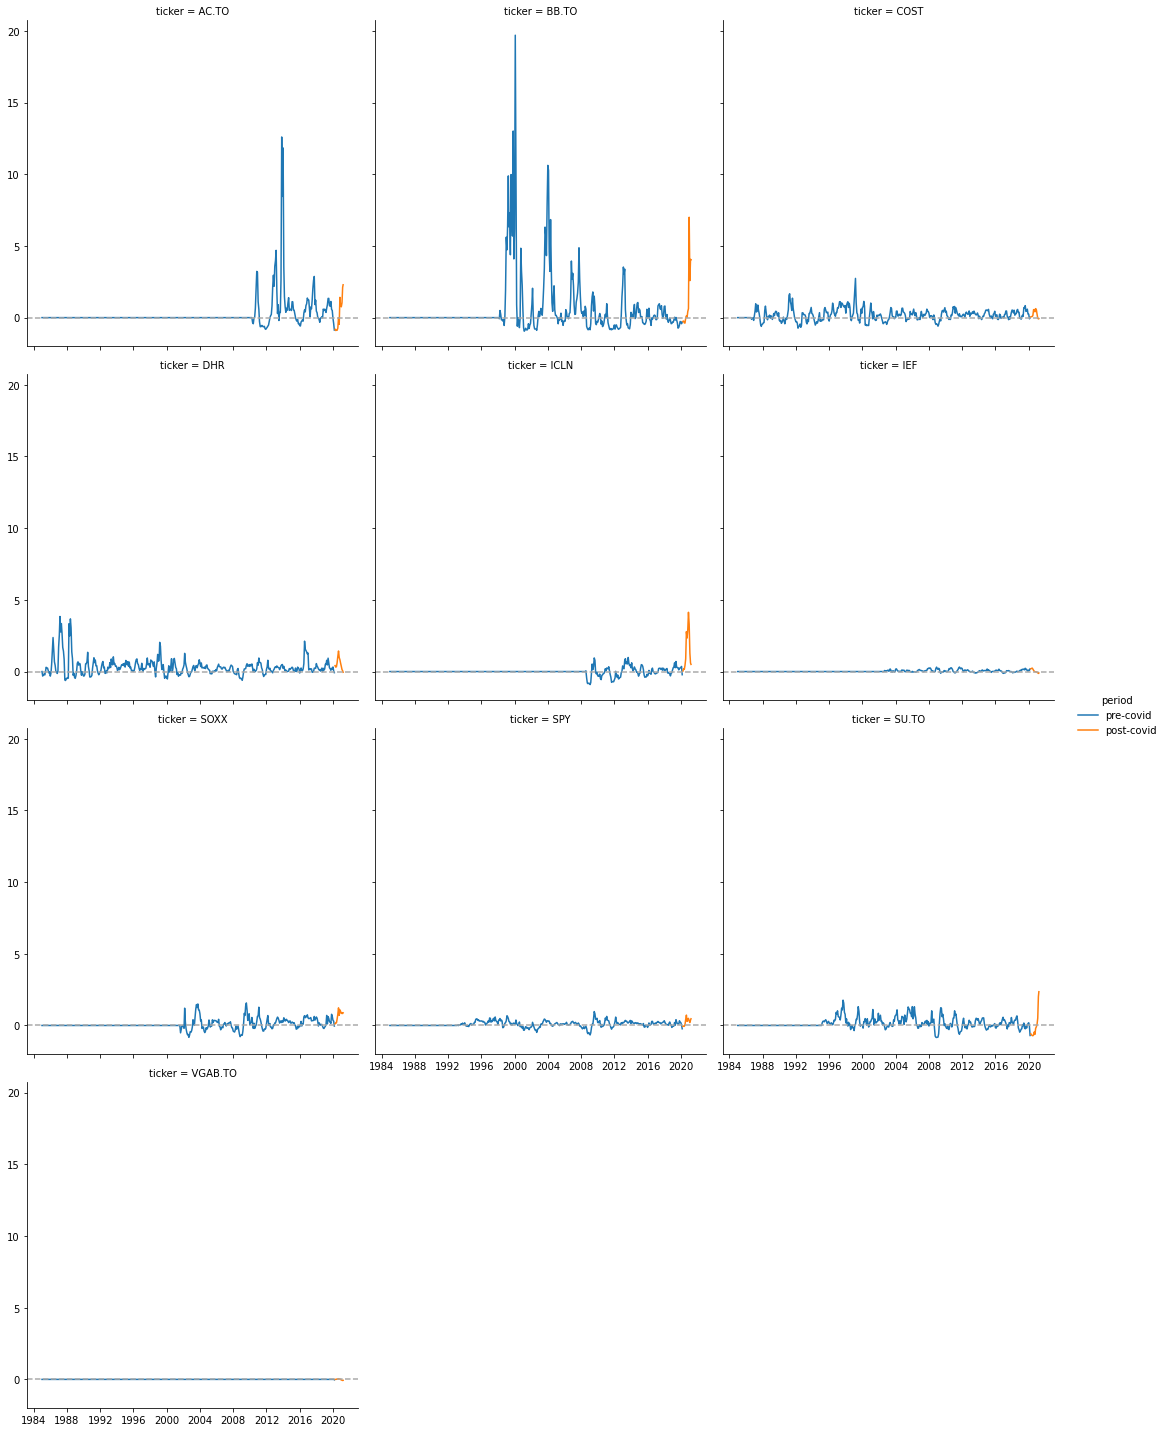

In [602]:
an.plot_rolling_annualized_return(mr_df, 6)

## 12-Month Rolling

,date,period,ticker,return
0,1985-01-01,pre-covid,AC.TO,0.000000
1,1985-02-01,pre-covid,AC.TO,0.000000
2,1985-03-01,pre-covid,AC.TO,0.000000
3,1985-04-01,pre-covid,AC.TO,0.000000
4,1985-05-01,pre-covid,AC.TO,0.000000
...,...,...,...,...
4355,2020-12-01,post-covid,VGAB.TO,0.001206
4356,2021-01-01,post-covid,VGAB.TO,-0.004990
4357,2021-02-01,post-covid,VGAB.TO,-0.022820
4358,2021-03-01,post-covid,VGAB.TO,-0.014630


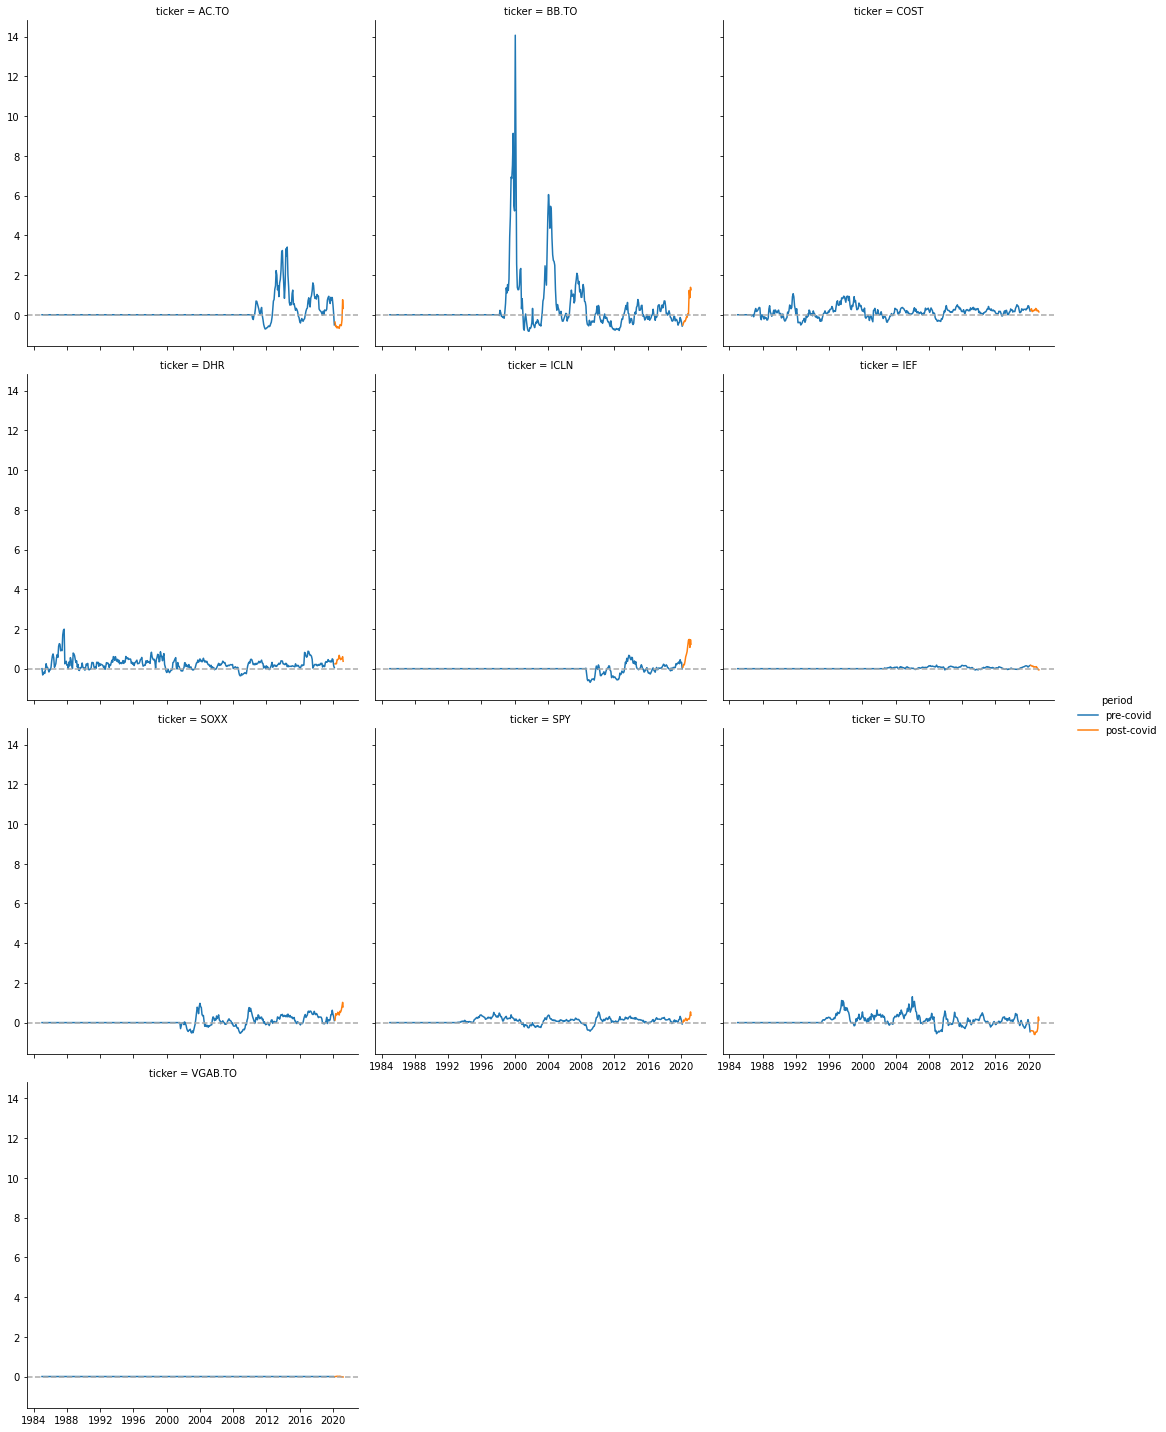

In [603]:
an.plot_rolling_annualized_return(mr_df, 12)

## 24-Month Rolling

,date,period,ticker,return
0,1985-01-01,pre-covid,AC.TO,0.0
1,1985-02-01,pre-covid,AC.TO,0.0
2,1985-03-01,pre-covid,AC.TO,0.0
3,1985-04-01,pre-covid,AC.TO,0.0
4,1985-05-01,pre-covid,AC.TO,0.0


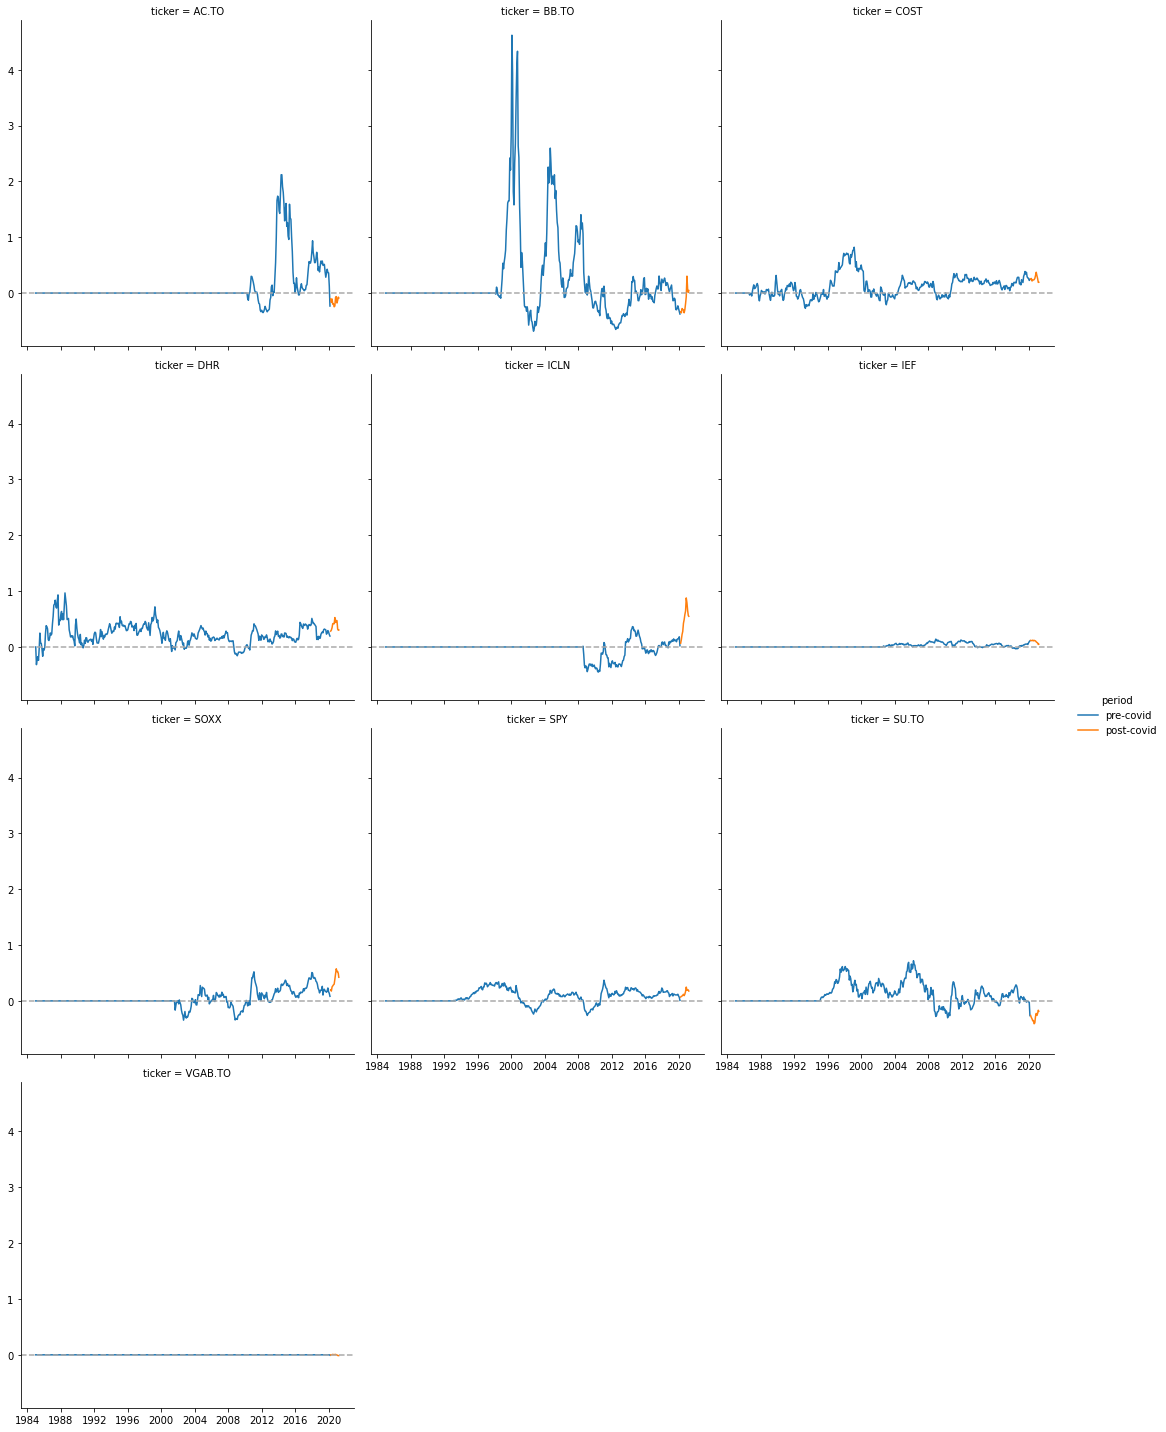

In [604]:
ar_rolling_24 = an.plot_rolling_annualized_return(mr_df, 12*2)
ar_rolling_24.head()

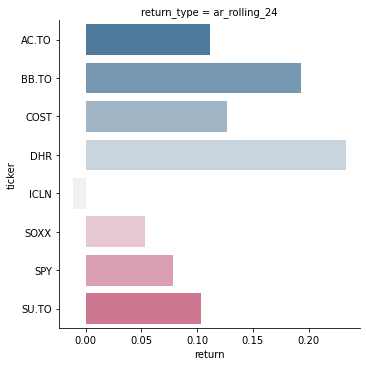

In [458]:
portfolio_soxx = (
  ar_rolling_24
    .query('ticker == "SOXX"')
    .assign(
      return_type = 'ar_rolling_24',
      portfolio = 'SOXX'
    )
)

portfolio_nvda = (
  ar_rolling_24
    .query('ticker == "NVDA"')
    .assign(
      return_type = 'ar_rolling_24',
      portfolio = 'NVDA'
    )
)

plot_df.head()

# pal = sns.color_palette("Greens_d", len(data))
# colors = [0 if c >=0 else 1 for c in data['performance']]

sns.catplot(
  x = 'return',
  y = 'ticker',
  col = 'return_type',
  kind = 'bar',
  data = plot_df,
  orient = 'h',
  ci = False,
  palette = sns.diverging_palette(240, 0, n=9)
)

In [606]:
r12_df[['COST']]

,COST
date,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN
...,...
2020-12-01,0.292800
2021-01-01,0.193810
2021-02-01,0.218449


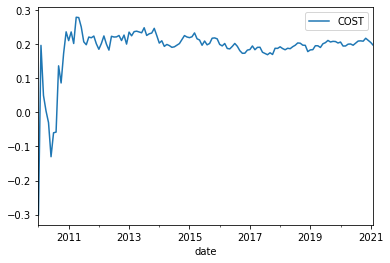

In [607]:
an.compute_annualized_return_from_date(
  mr_df[['COST']],
  from_date = '2010-01-01'
).plot();

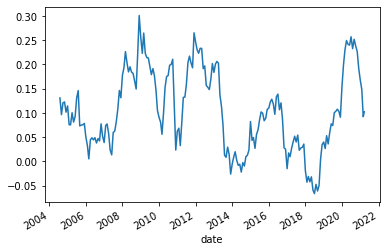

In [608]:
x = mmd_df['adjusted_close']['IEF'].dropna()
(x / x.shift(24) - 1).loc['2000':].plot();

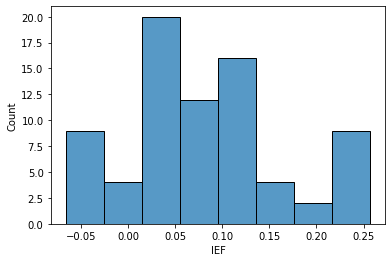

In [609]:
sns.histplot((x / x.shift(24) - 1).loc['2015':]);

## 10-Year Rolling

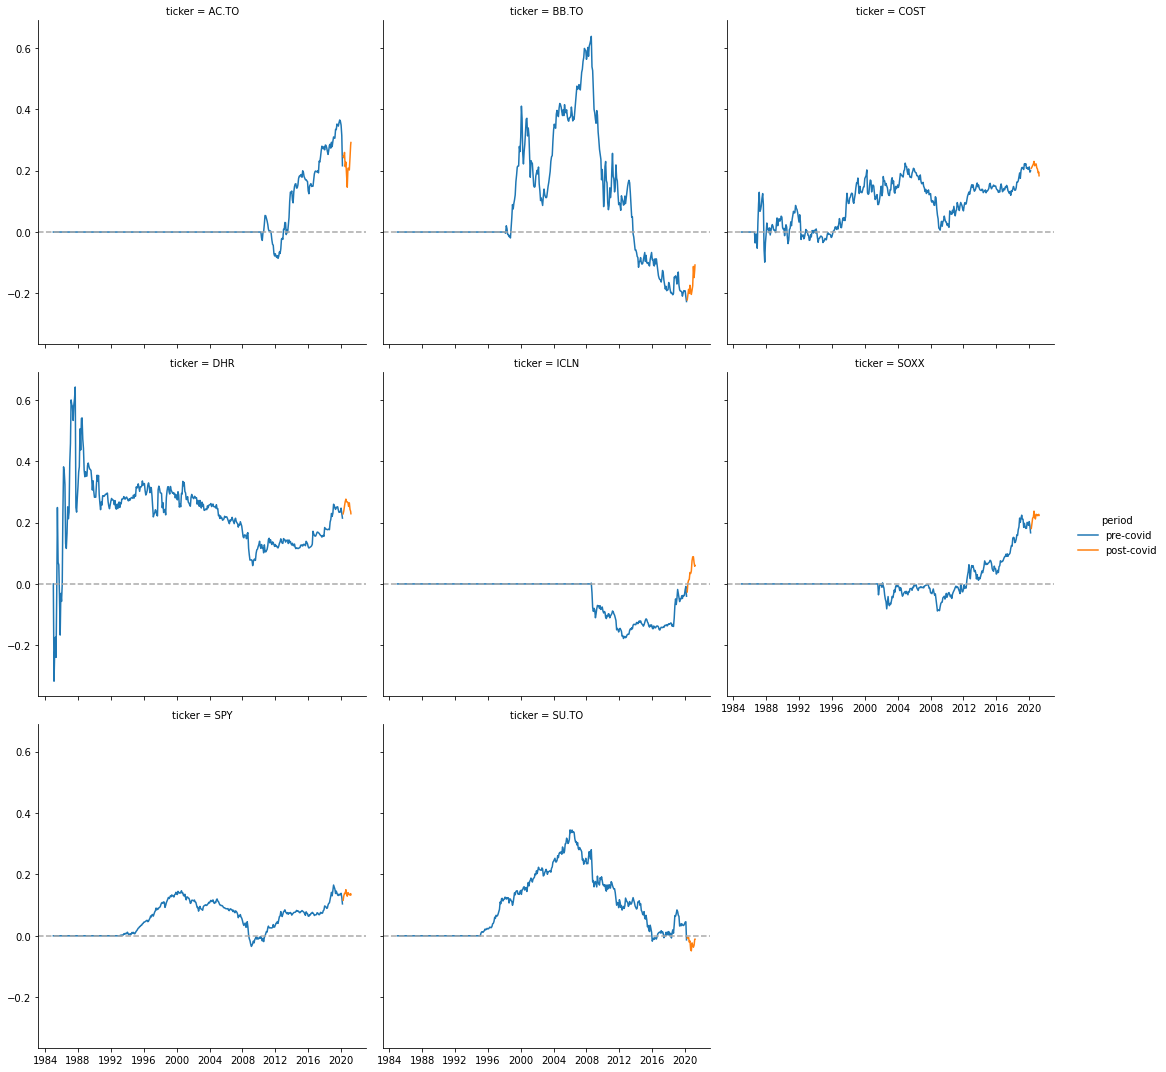

In [416]:
an.plot_rolling_annualized_return(mr_df, 12*10)

# 4. Review returns

## 6-Month

## 12-Month Rolling

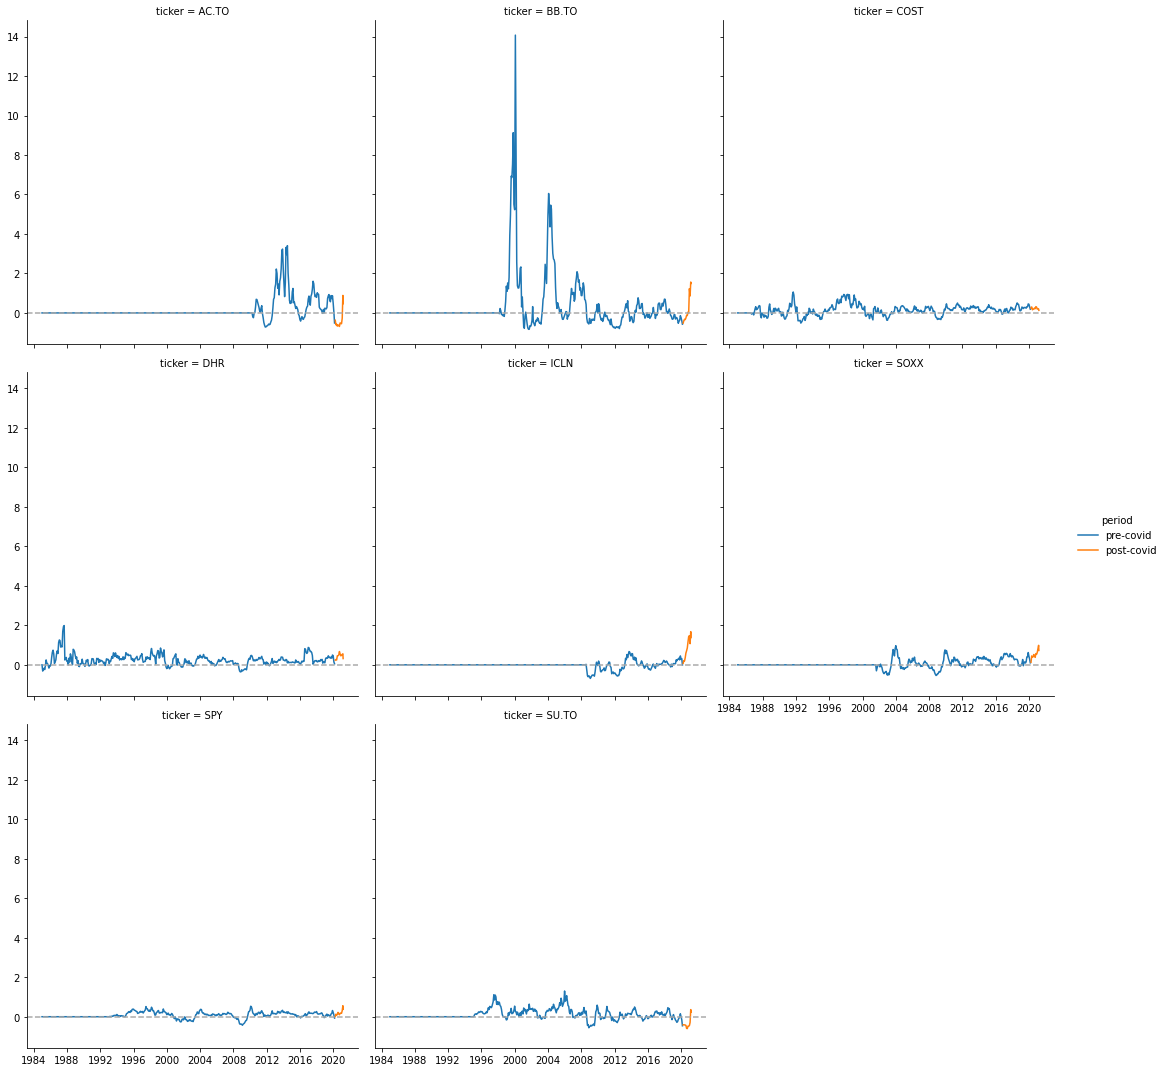

In [388]:
an.plot_rolling_annualized_return(mr_df, 12)

## 24-Month Rolling

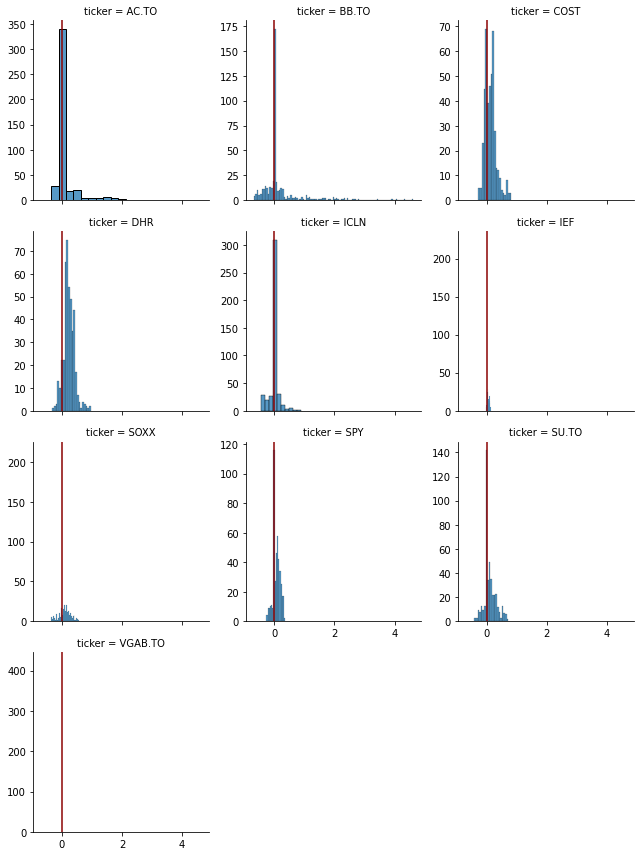

In [676]:
f = sns.FacetGrid(
  data = ar_rolling_24,
  col = 'ticker',
  #hue = 'period',
  sharey = False,
  col_wrap = 3
)

f.map(sns.histplot, 'return');
f.map(plt.axvline, x=0, color = 'darkred')

,date,period,ticker,return
0,1985-01-01,pre-covid,AC.TO,0.0
1,1985-02-01,pre-covid,AC.TO,0.0
2,1985-03-01,pre-covid,AC.TO,0.0
3,1985-04-01,pre-covid,AC.TO,0.0
4,1985-05-01,pre-covid,AC.TO,0.0


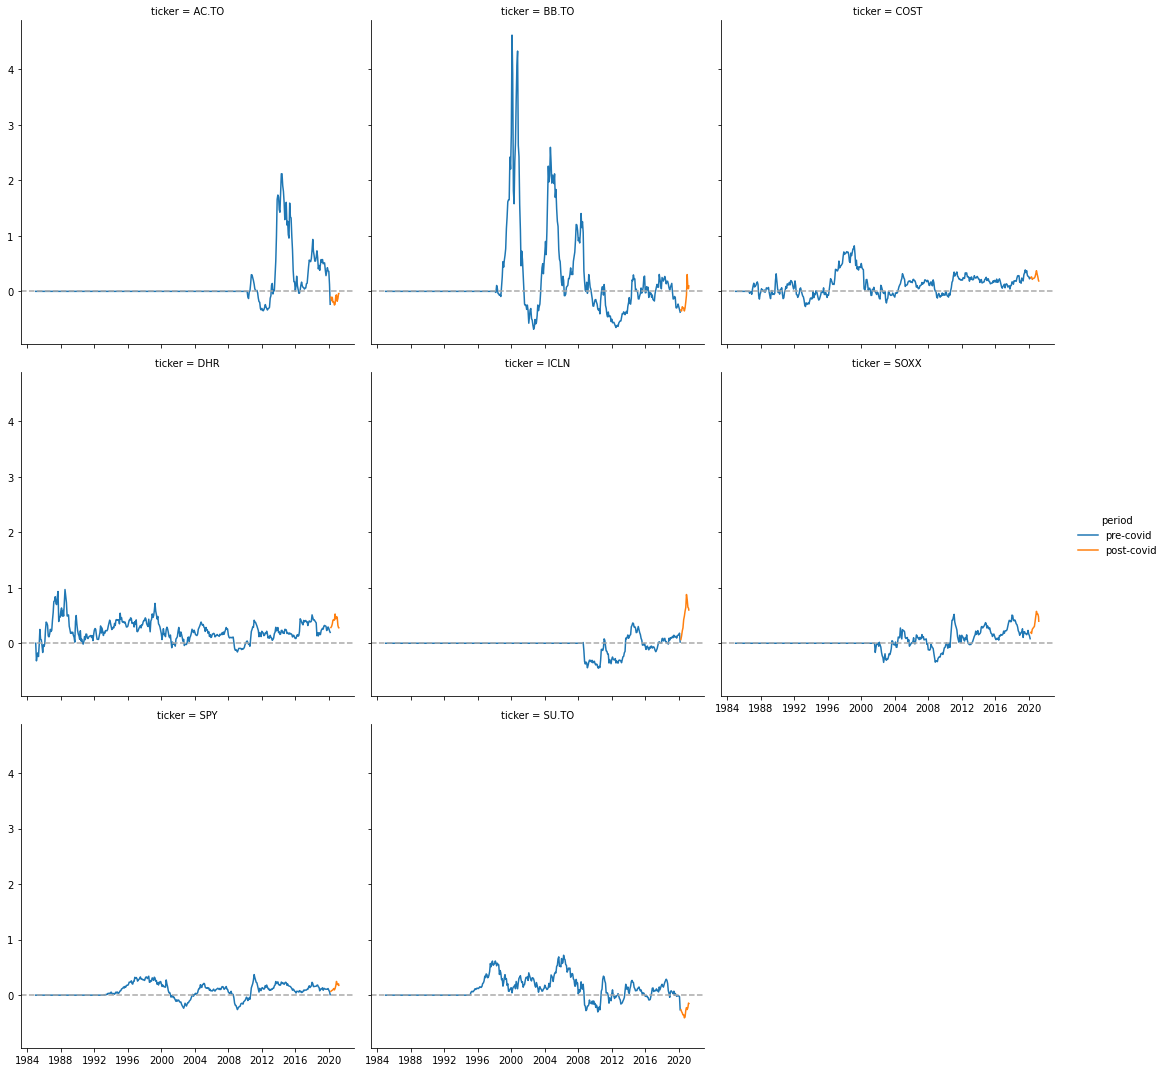

In [418]:
ar_rolling_24 = an.plot_rolling_annualized_return(mr_df, 12*2)
ar_rolling_24.head()

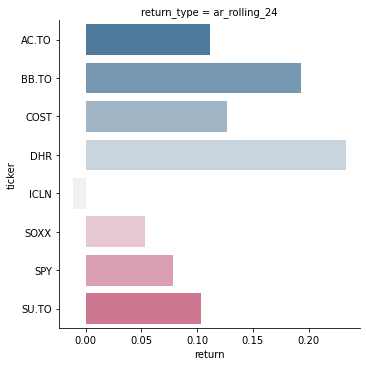

In [458]:
portfolio_soxx = (
  ar_rolling_24
    .query('ticker == "SOXX"')
    .assign(
      return_type = 'ar_rolling_24',
      portfolio = 'SOXX'
    )
)

portfolio_nvda = (
  ar_rolling_24
    .query('ticker == "NVDA"')
    .assign(
      return_type = 'ar_rolling_24',
      portfolio = 'NVDA'
    )
)

plot_df.head()

# pal = sns.color_palette("Greens_d", len(data))
# colors = [0 if c >=0 else 1 for c in data['performance']]

sns.catplot(
  x = 'return',
  y = 'ticker',
  col = 'return_type',
  kind = 'bar',
  data = plot_df,
  orient = 'h',
  ci = False,
  palette = sns.diverging_palette(240, 0, n=9)
)

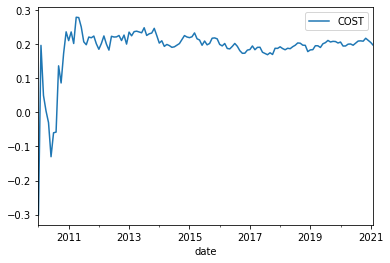

In [412]:
an.compute_annualized_return_from_date(
  mr_df[['COST']],
  from_date = '2010-01-01'
).plot();

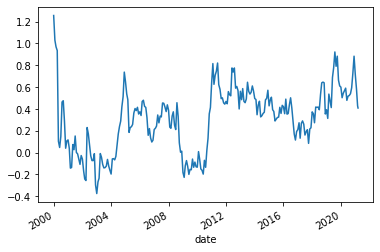

In [414]:
x = mmd_df['adjusted_close']['COST'].dropna()
(x / x.shift(24) - 1).loc['2000':].plot();

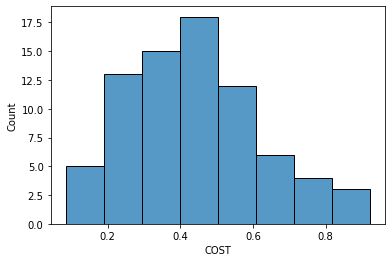

In [415]:
sns.histplot((x / x.shift(24) - 1).loc['2015':]);

## 10-Year Rolling

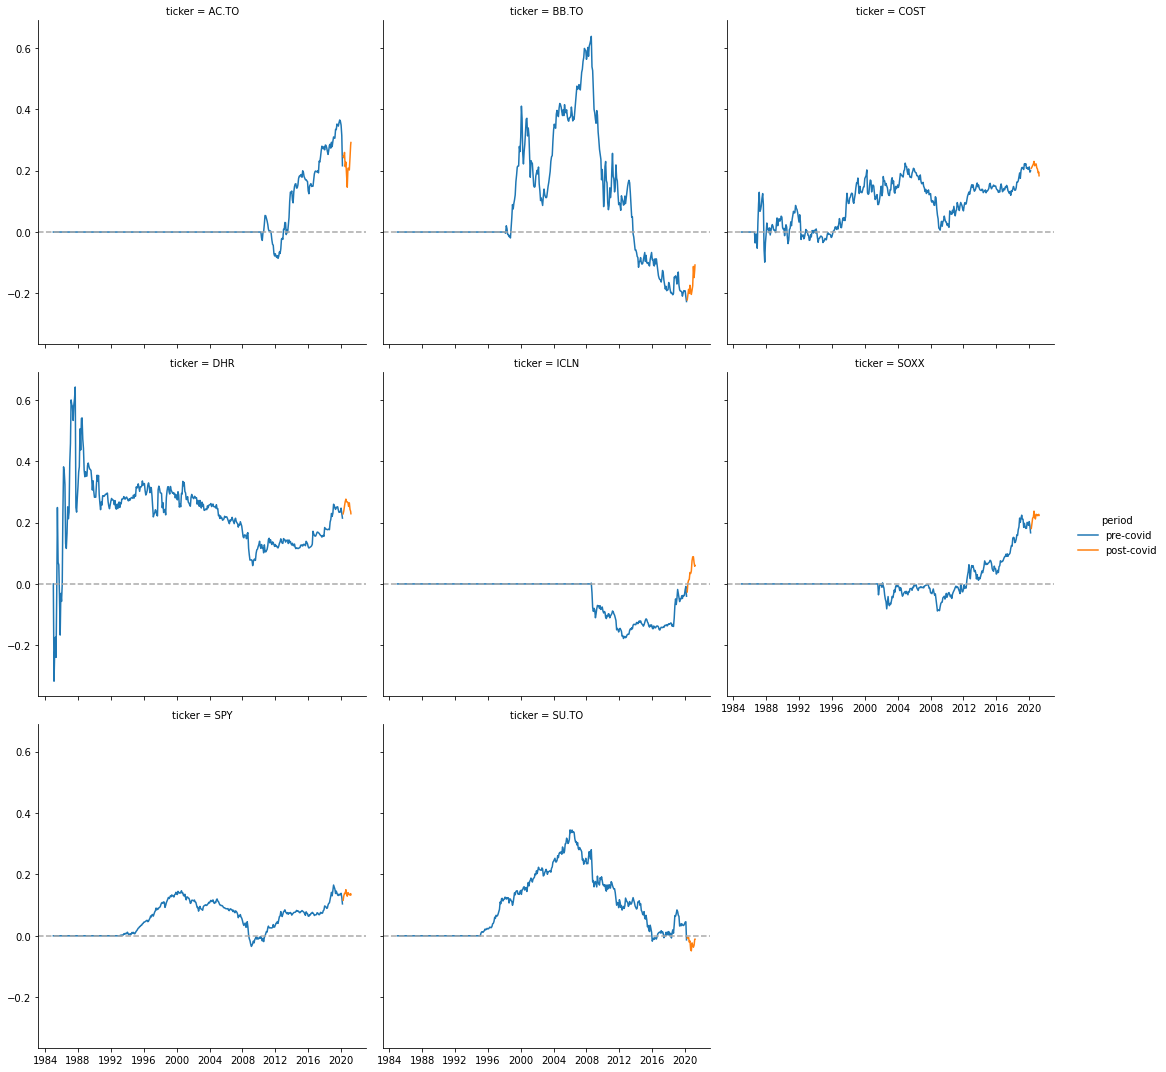

In [416]:
an.plot_rolling_annualized_return(mr_df, 12*10)

# 5. Review annualized returns over specific periods

## From 2010

### Excluding COVID

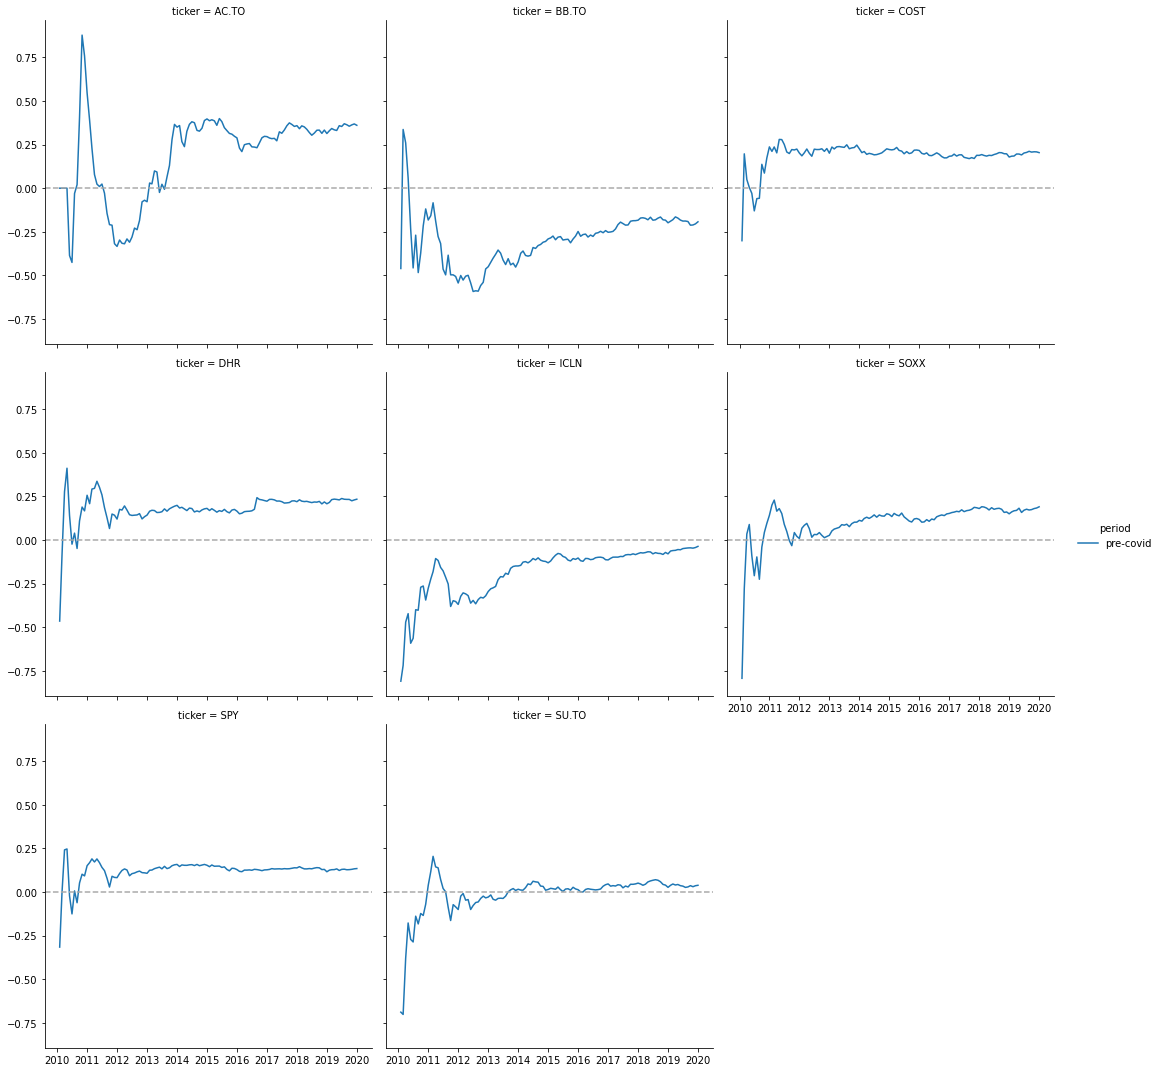

In [417]:
an.plot_annualized_return_from_date(
  returns_df = mr_df,
  from_date = '2010-01-01',
  to_date = '2020-01-01'
)

### Including COVID

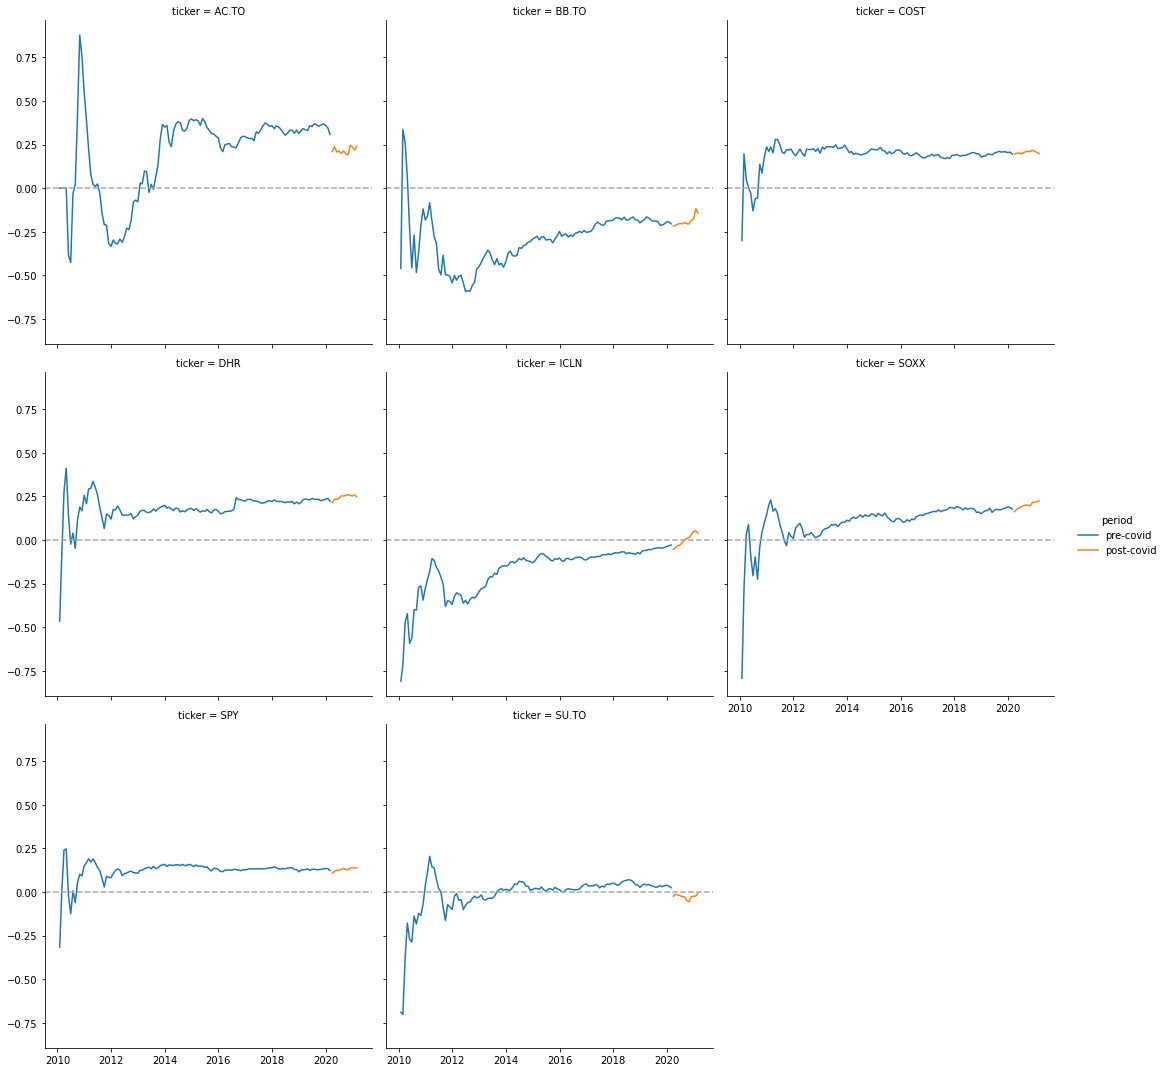

In [395]:
an.plot_annualized_return_from_date(
  returns_df = mr_df,
  from_date = '2010-01-01'
)

## From 2015

### Excluding COVID

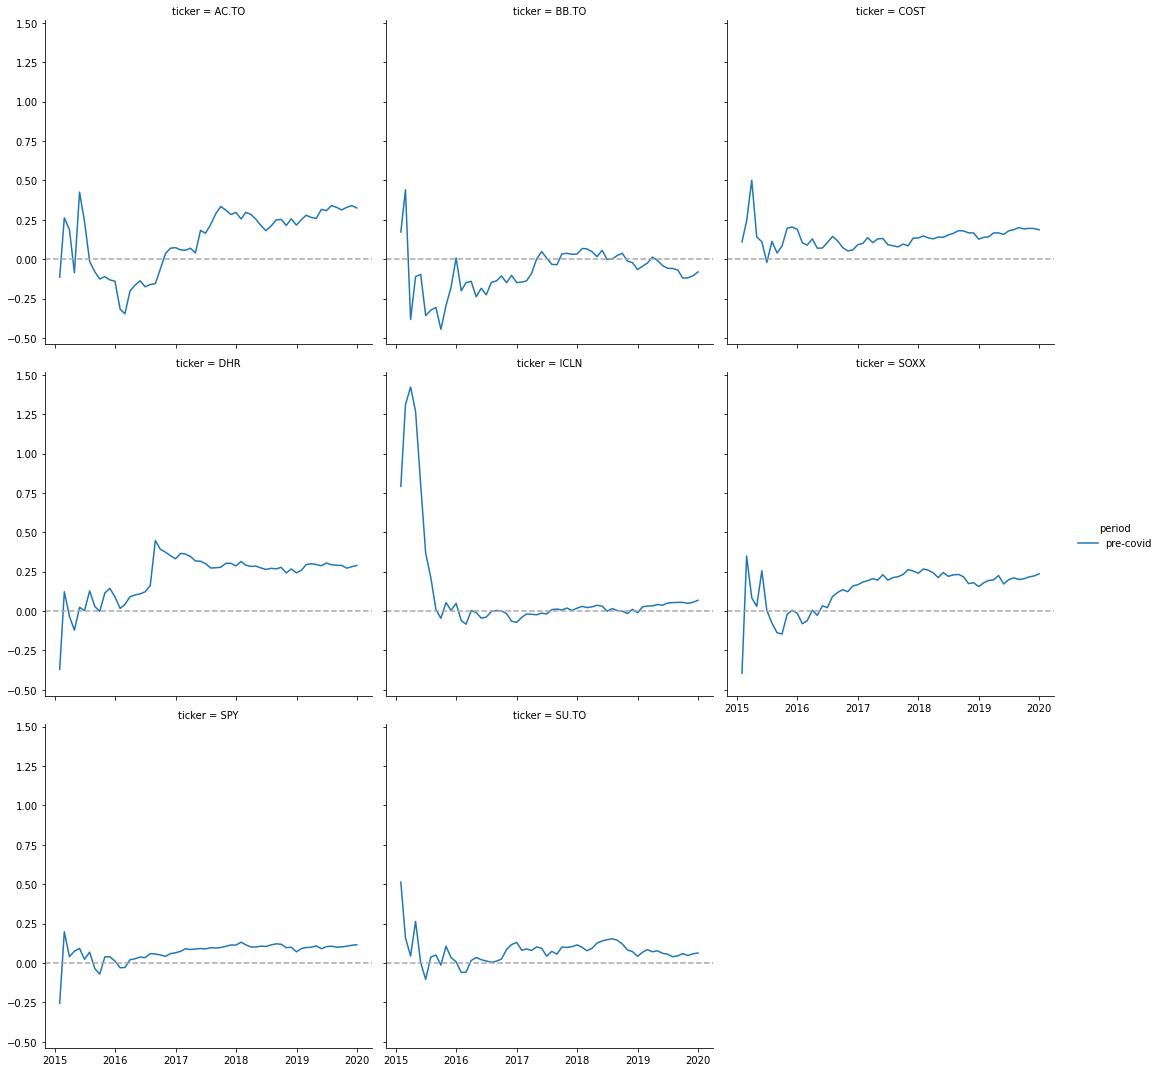

In [396]:
an.plot_annualized_return_from_date(
  returns_df = mr_df,
  from_date = '2015-01-01',
  to_date = '2020-01-01'
)

### Including COVID

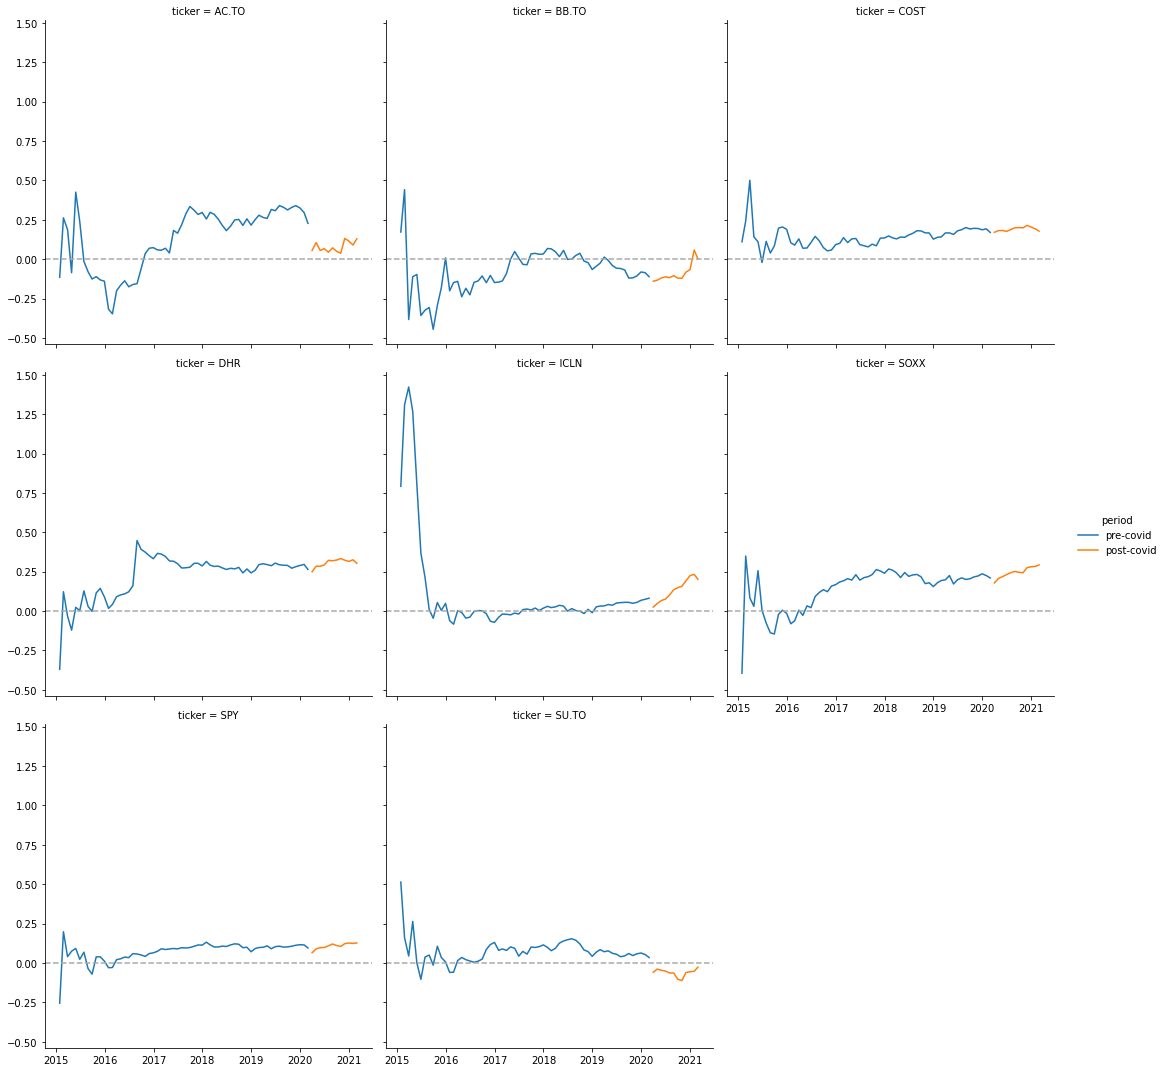

In [397]:
an.plot_annualized_return_from_date(
  returns_df = mr_df,
  from_date = '2015-01-01'
)

## Post-COVID

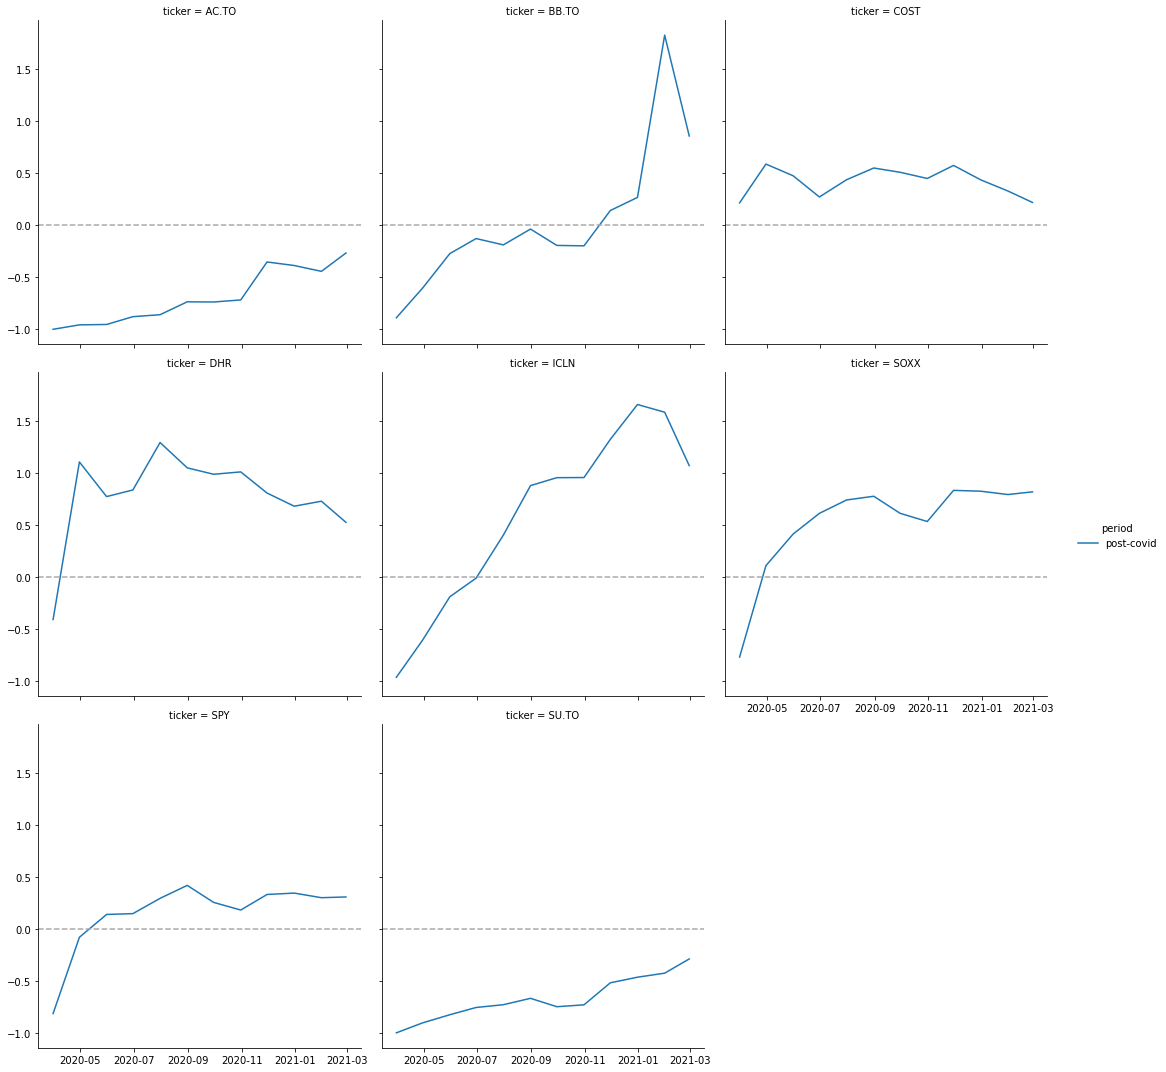

In [398]:
an.plot_annualized_return_from_date(
  returns_df = mr_df,
  from_date = '2020-03-01'
)

# 5. Review risk

## Semi-Deviation

### From 2010

#### Excluding COVID

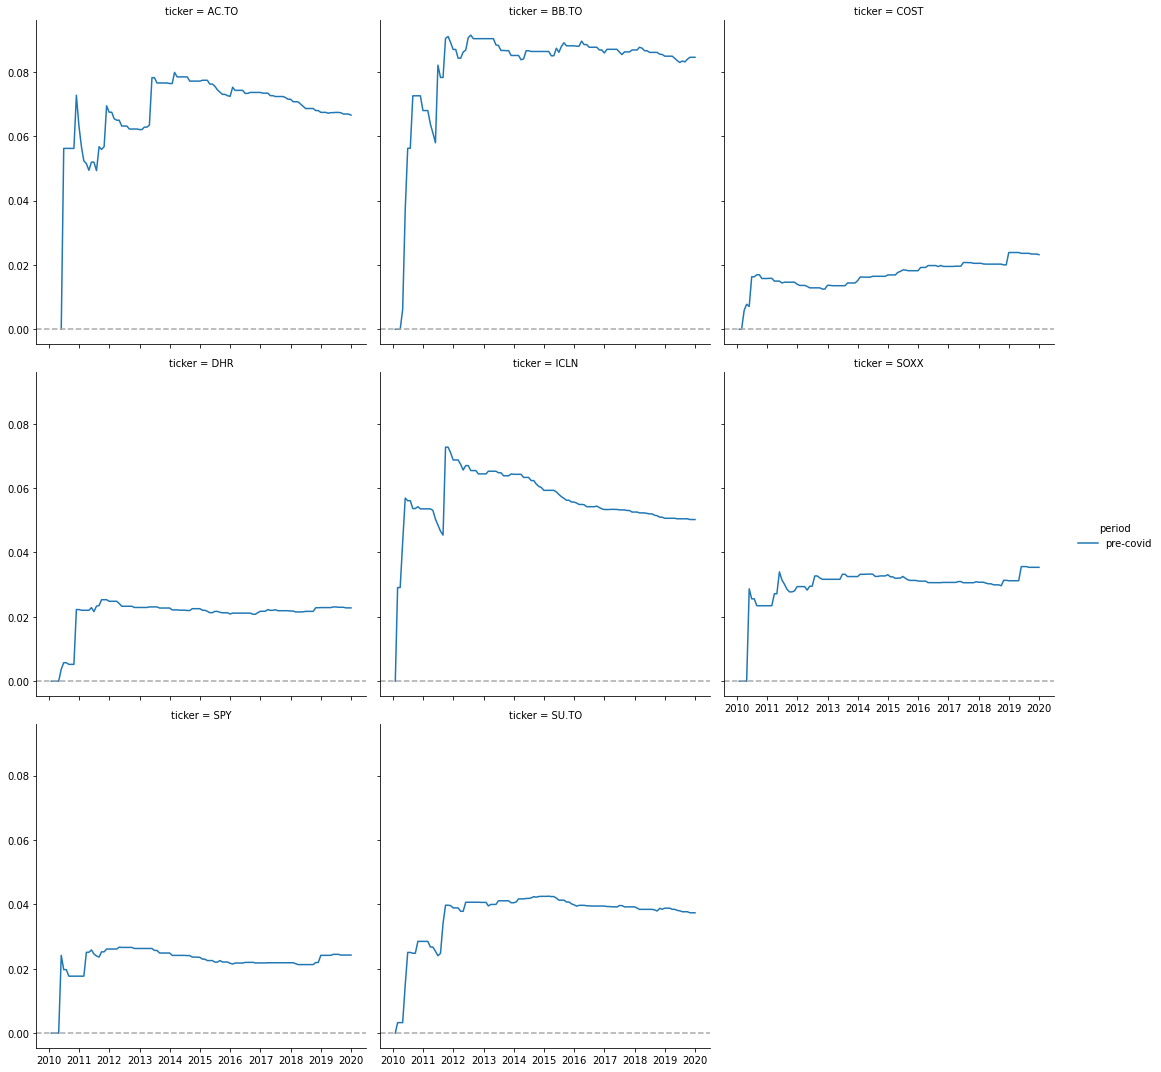

In [399]:
an.plot_from_date(erk.semideviation, mr_df, '2010-01-01', '2020-01-01')

#### Including COVID

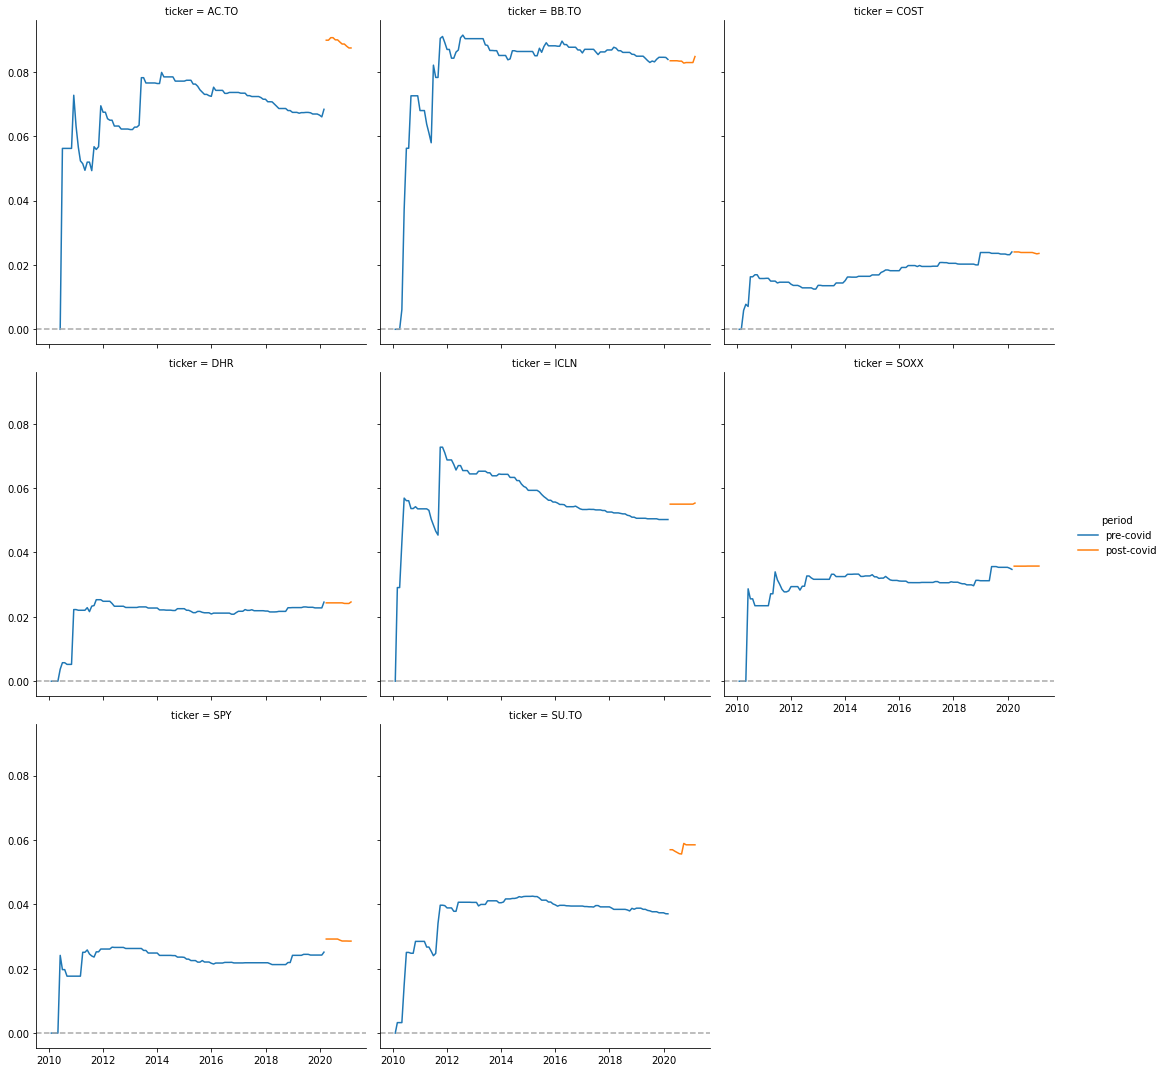

In [400]:
an.plot_from_date(erk.semideviation, mr_df, '2010-01-01')

### From 2015

#### Excluding COVID

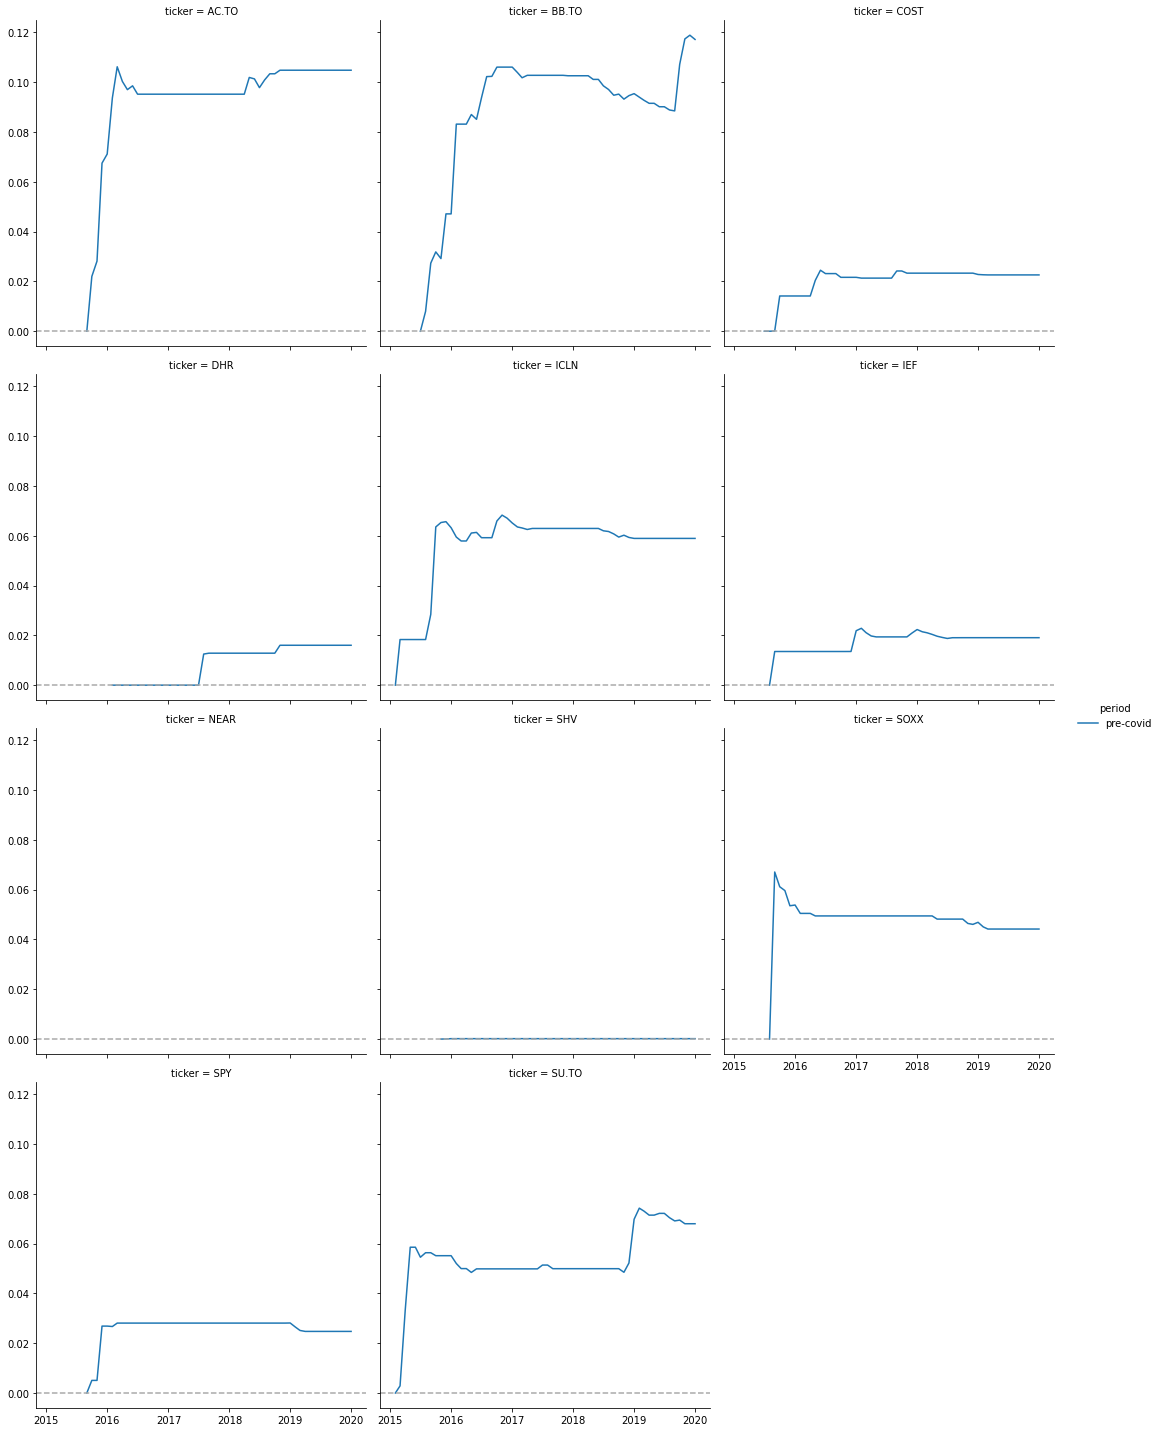

In [690]:
an.plot_from_date(erk.semideviation, r6_df, '2015-01-01', '2020-01-01')

#### Including COVID

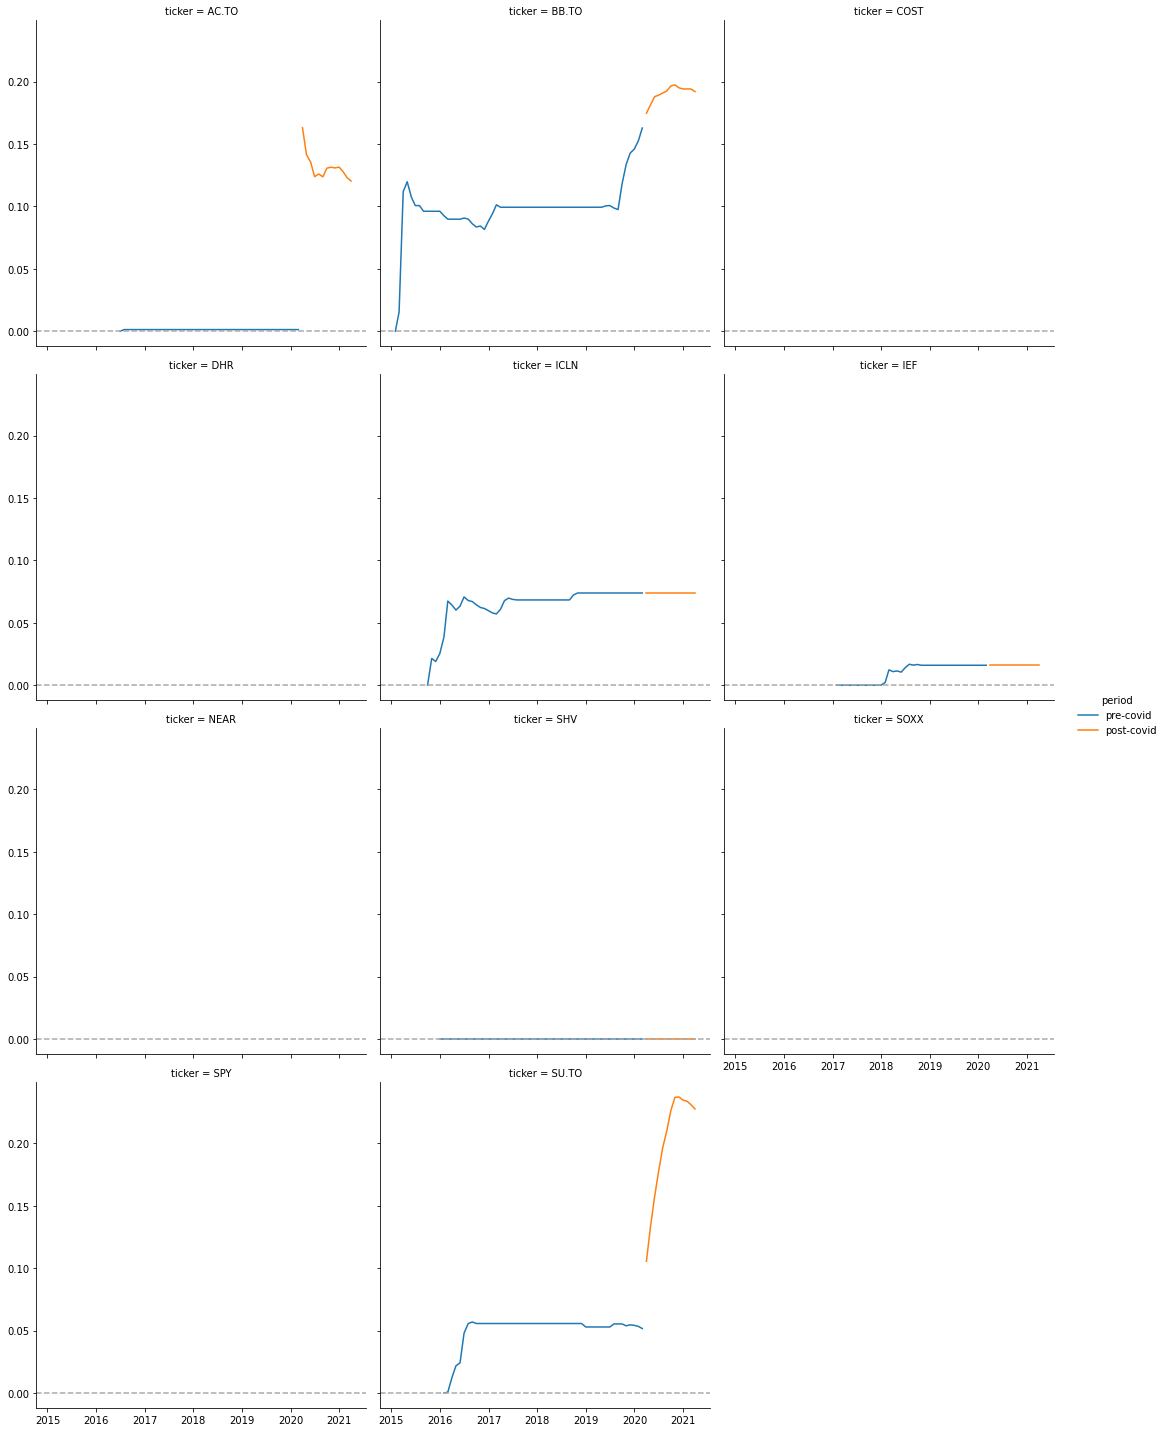

In [693]:
an.plot_from_date(erk.semideviation, r24_df, '2015-01-01')

### Post-COVID

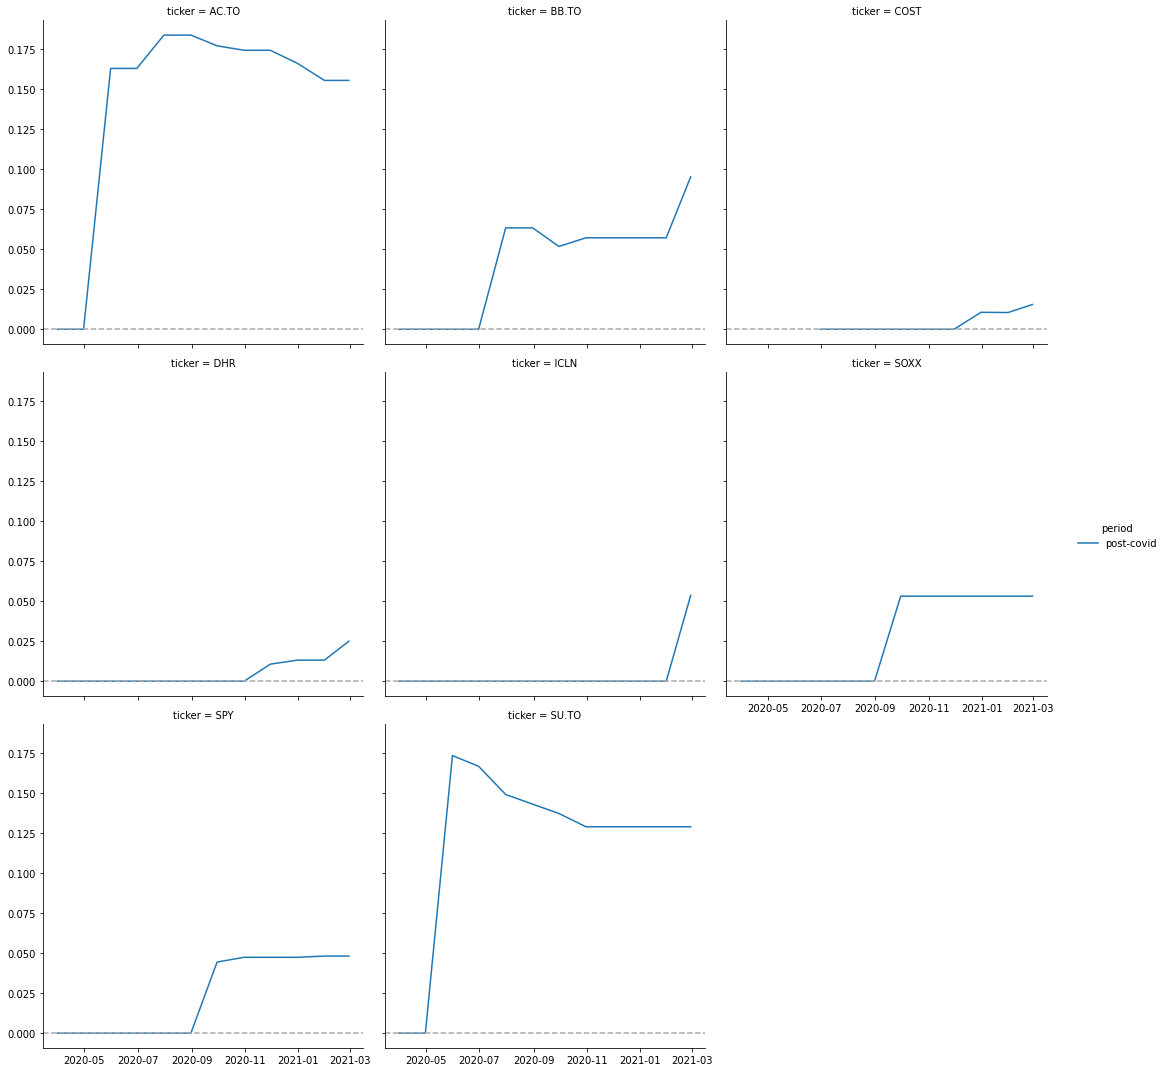

In [403]:
an.plot_from_date(erk.semideviation, mr_df, '2020-03-01')

## Value at Risk

### From 2010

#### Excluding COVID

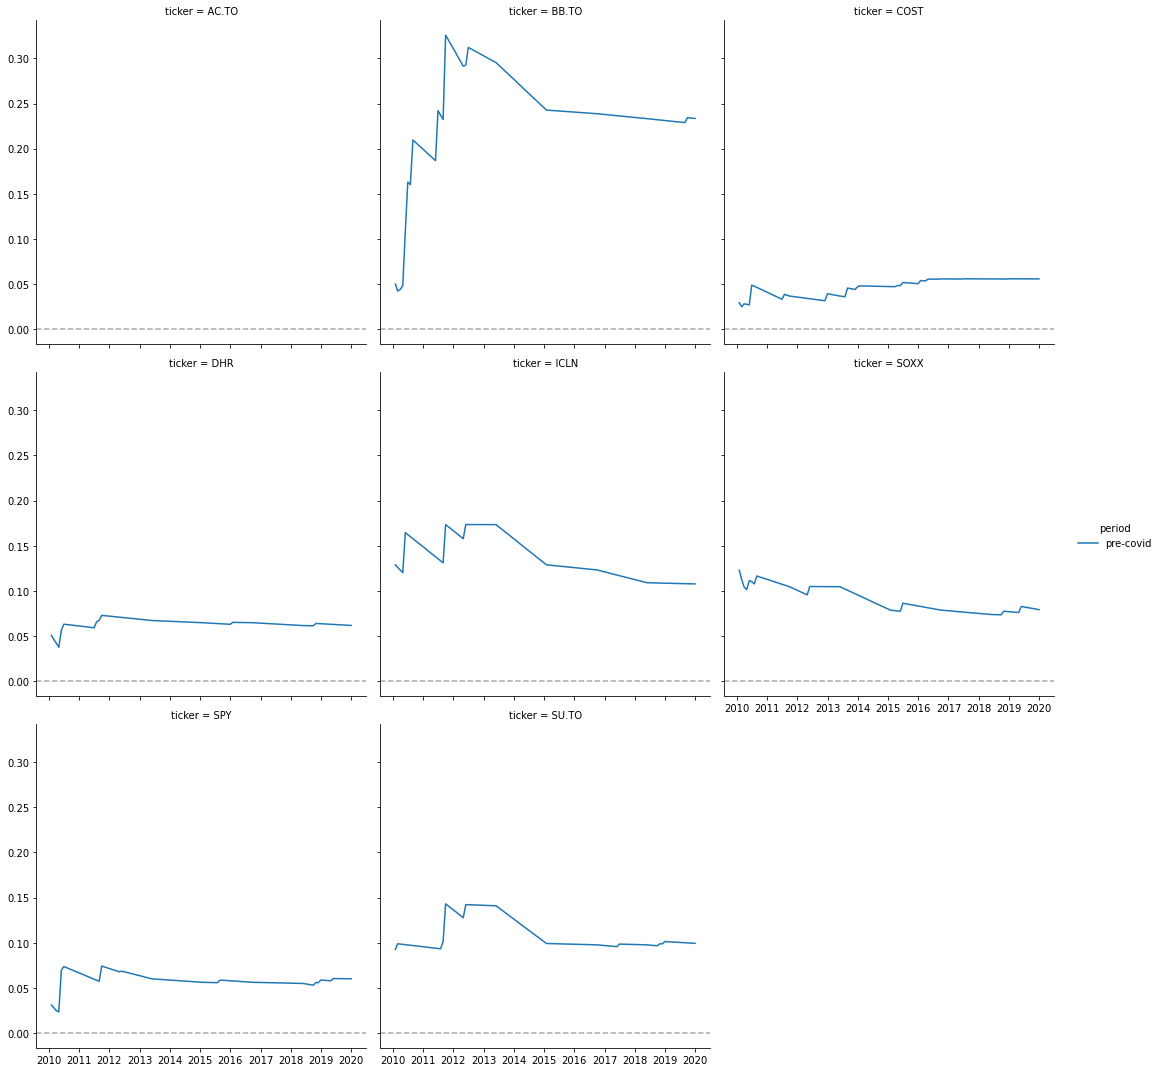

In [404]:
an.plot_from_date(erk.var_historic, mr_df, '2010-01-01', '2020-01-01')

#### Including COVID

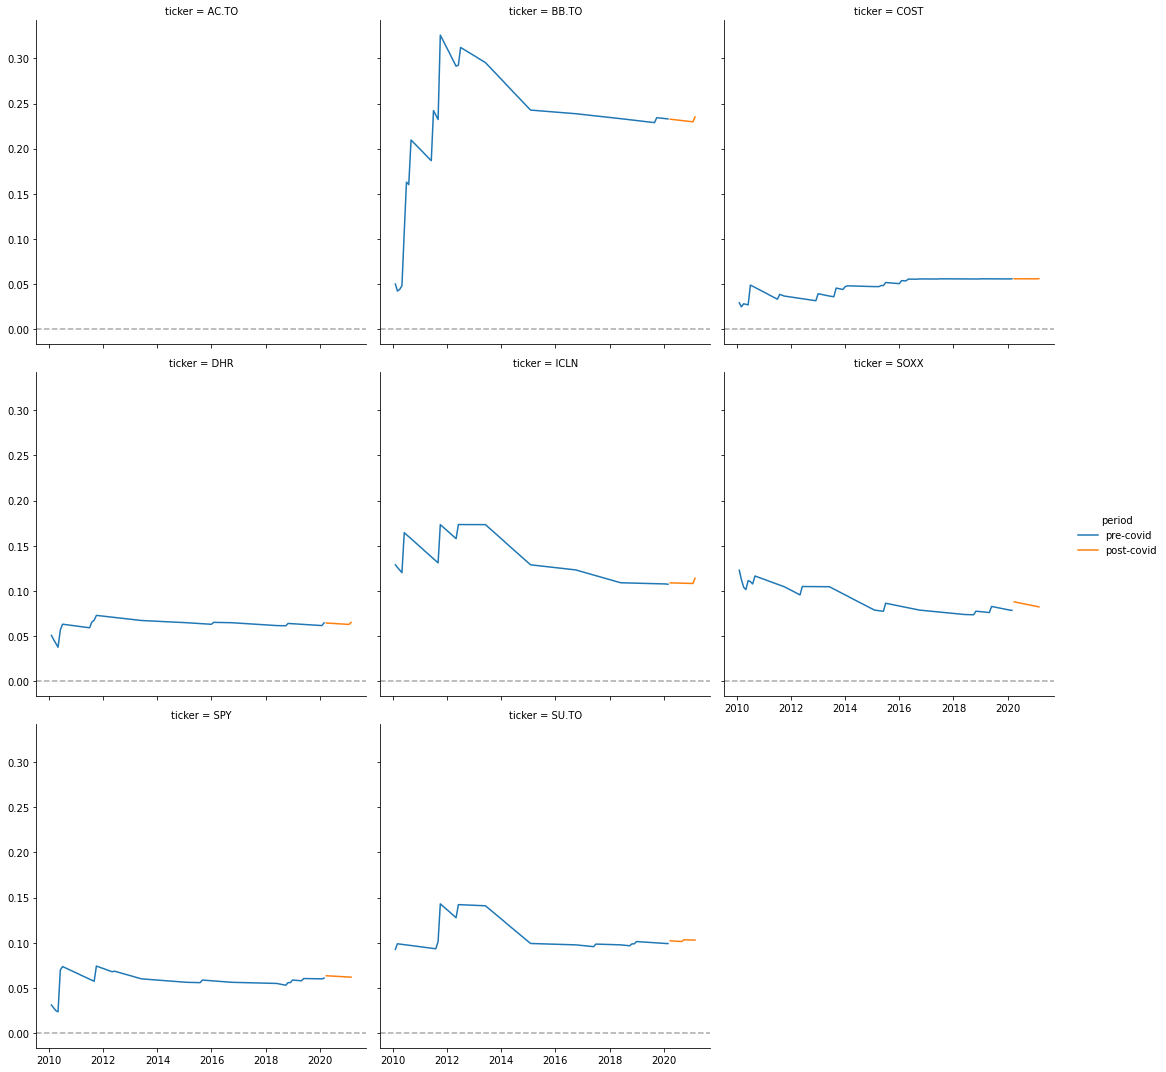

In [405]:
an.plot_from_date(erk.var_historic, mr_df, '2010-01-01')

### From 2015

#### Excluding COVID

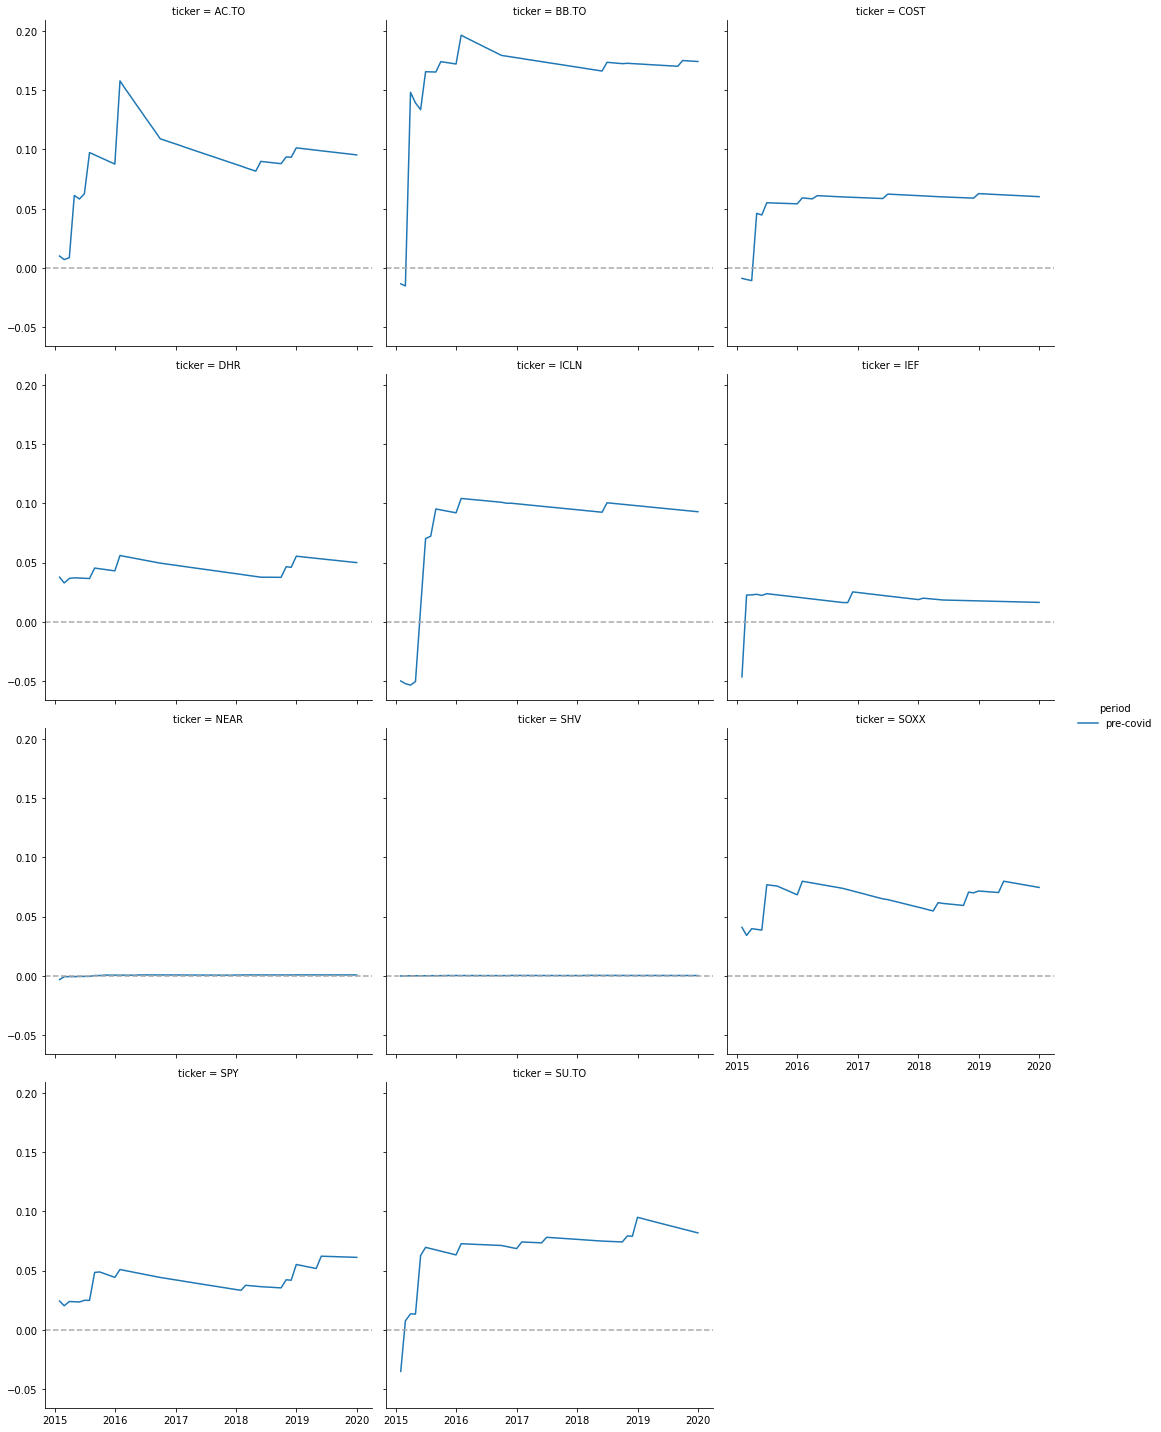

In [694]:
an.plot_from_date(erk.var_historic, r1_df, '2015-01-01', '2020-01-01')

#### Including COVID

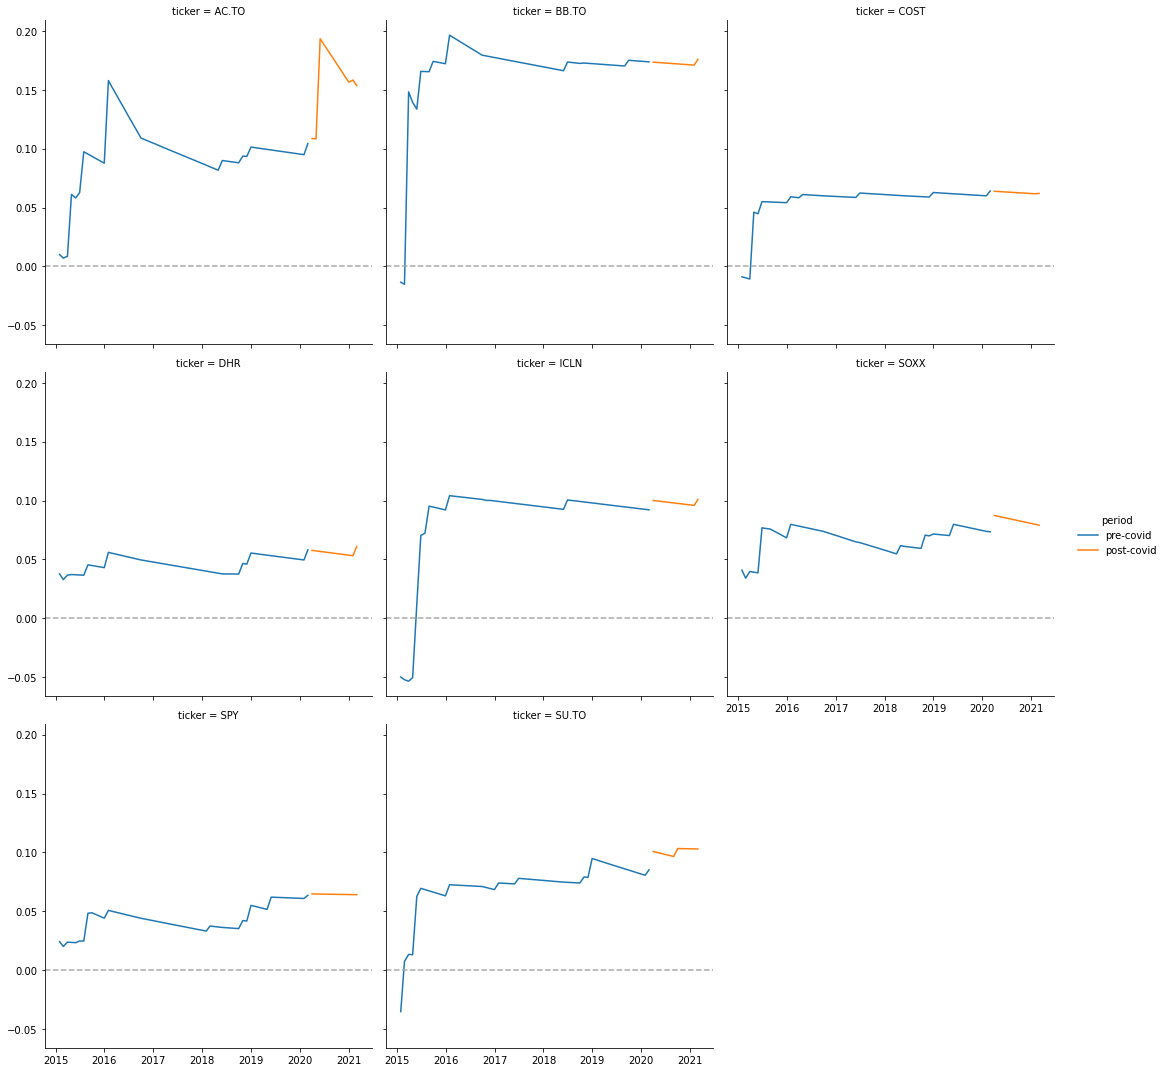

In [407]:
an.plot_from_date(erk.var_historic, mr_df, '2015-01-01')

### Post-COVID

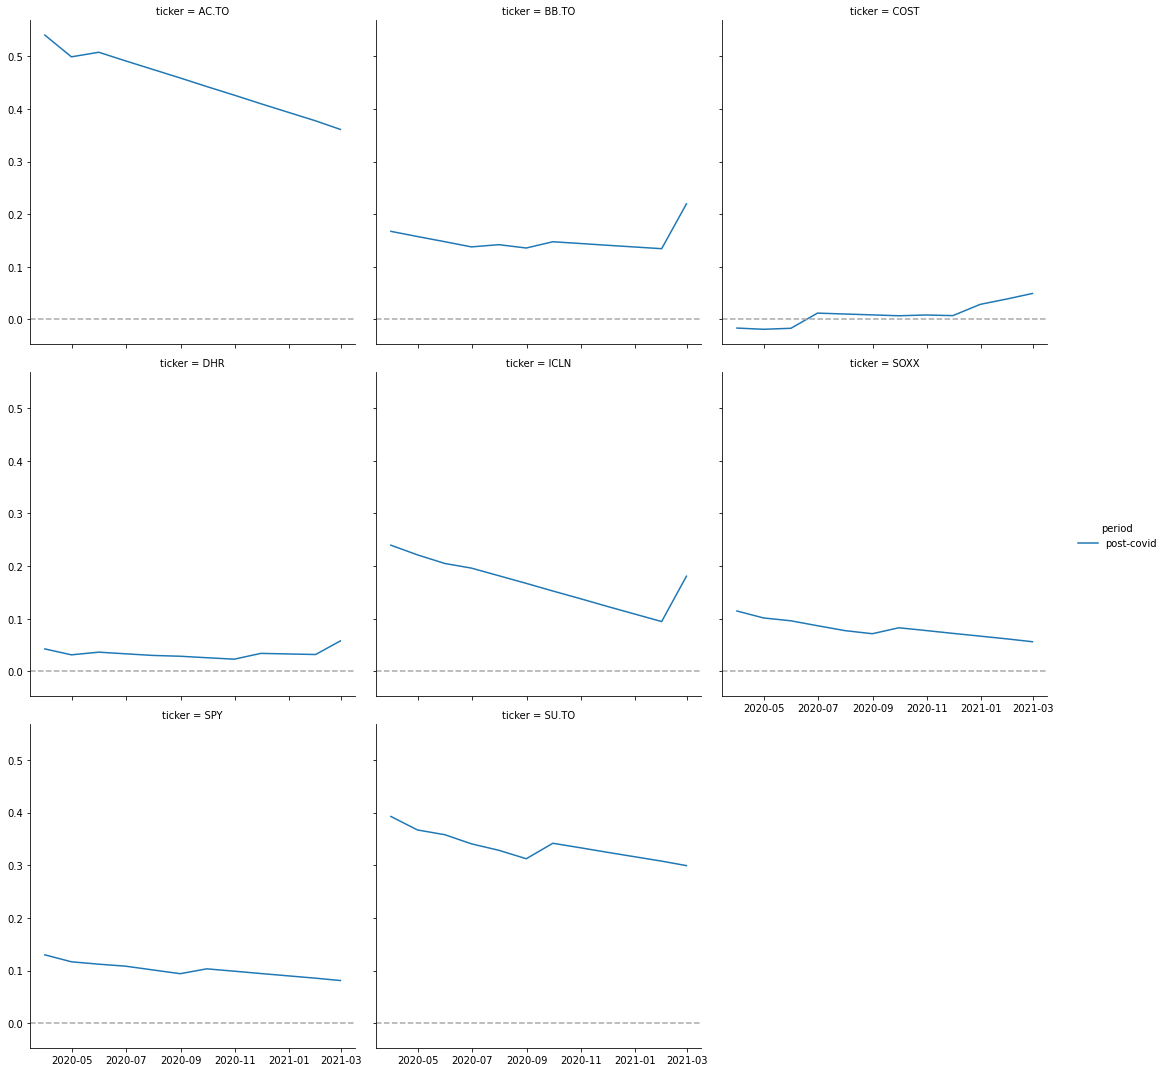

In [408]:
an.plot_from_date(erk.var_historic, mr_df, '2020-03-01')

# 6. Correlation

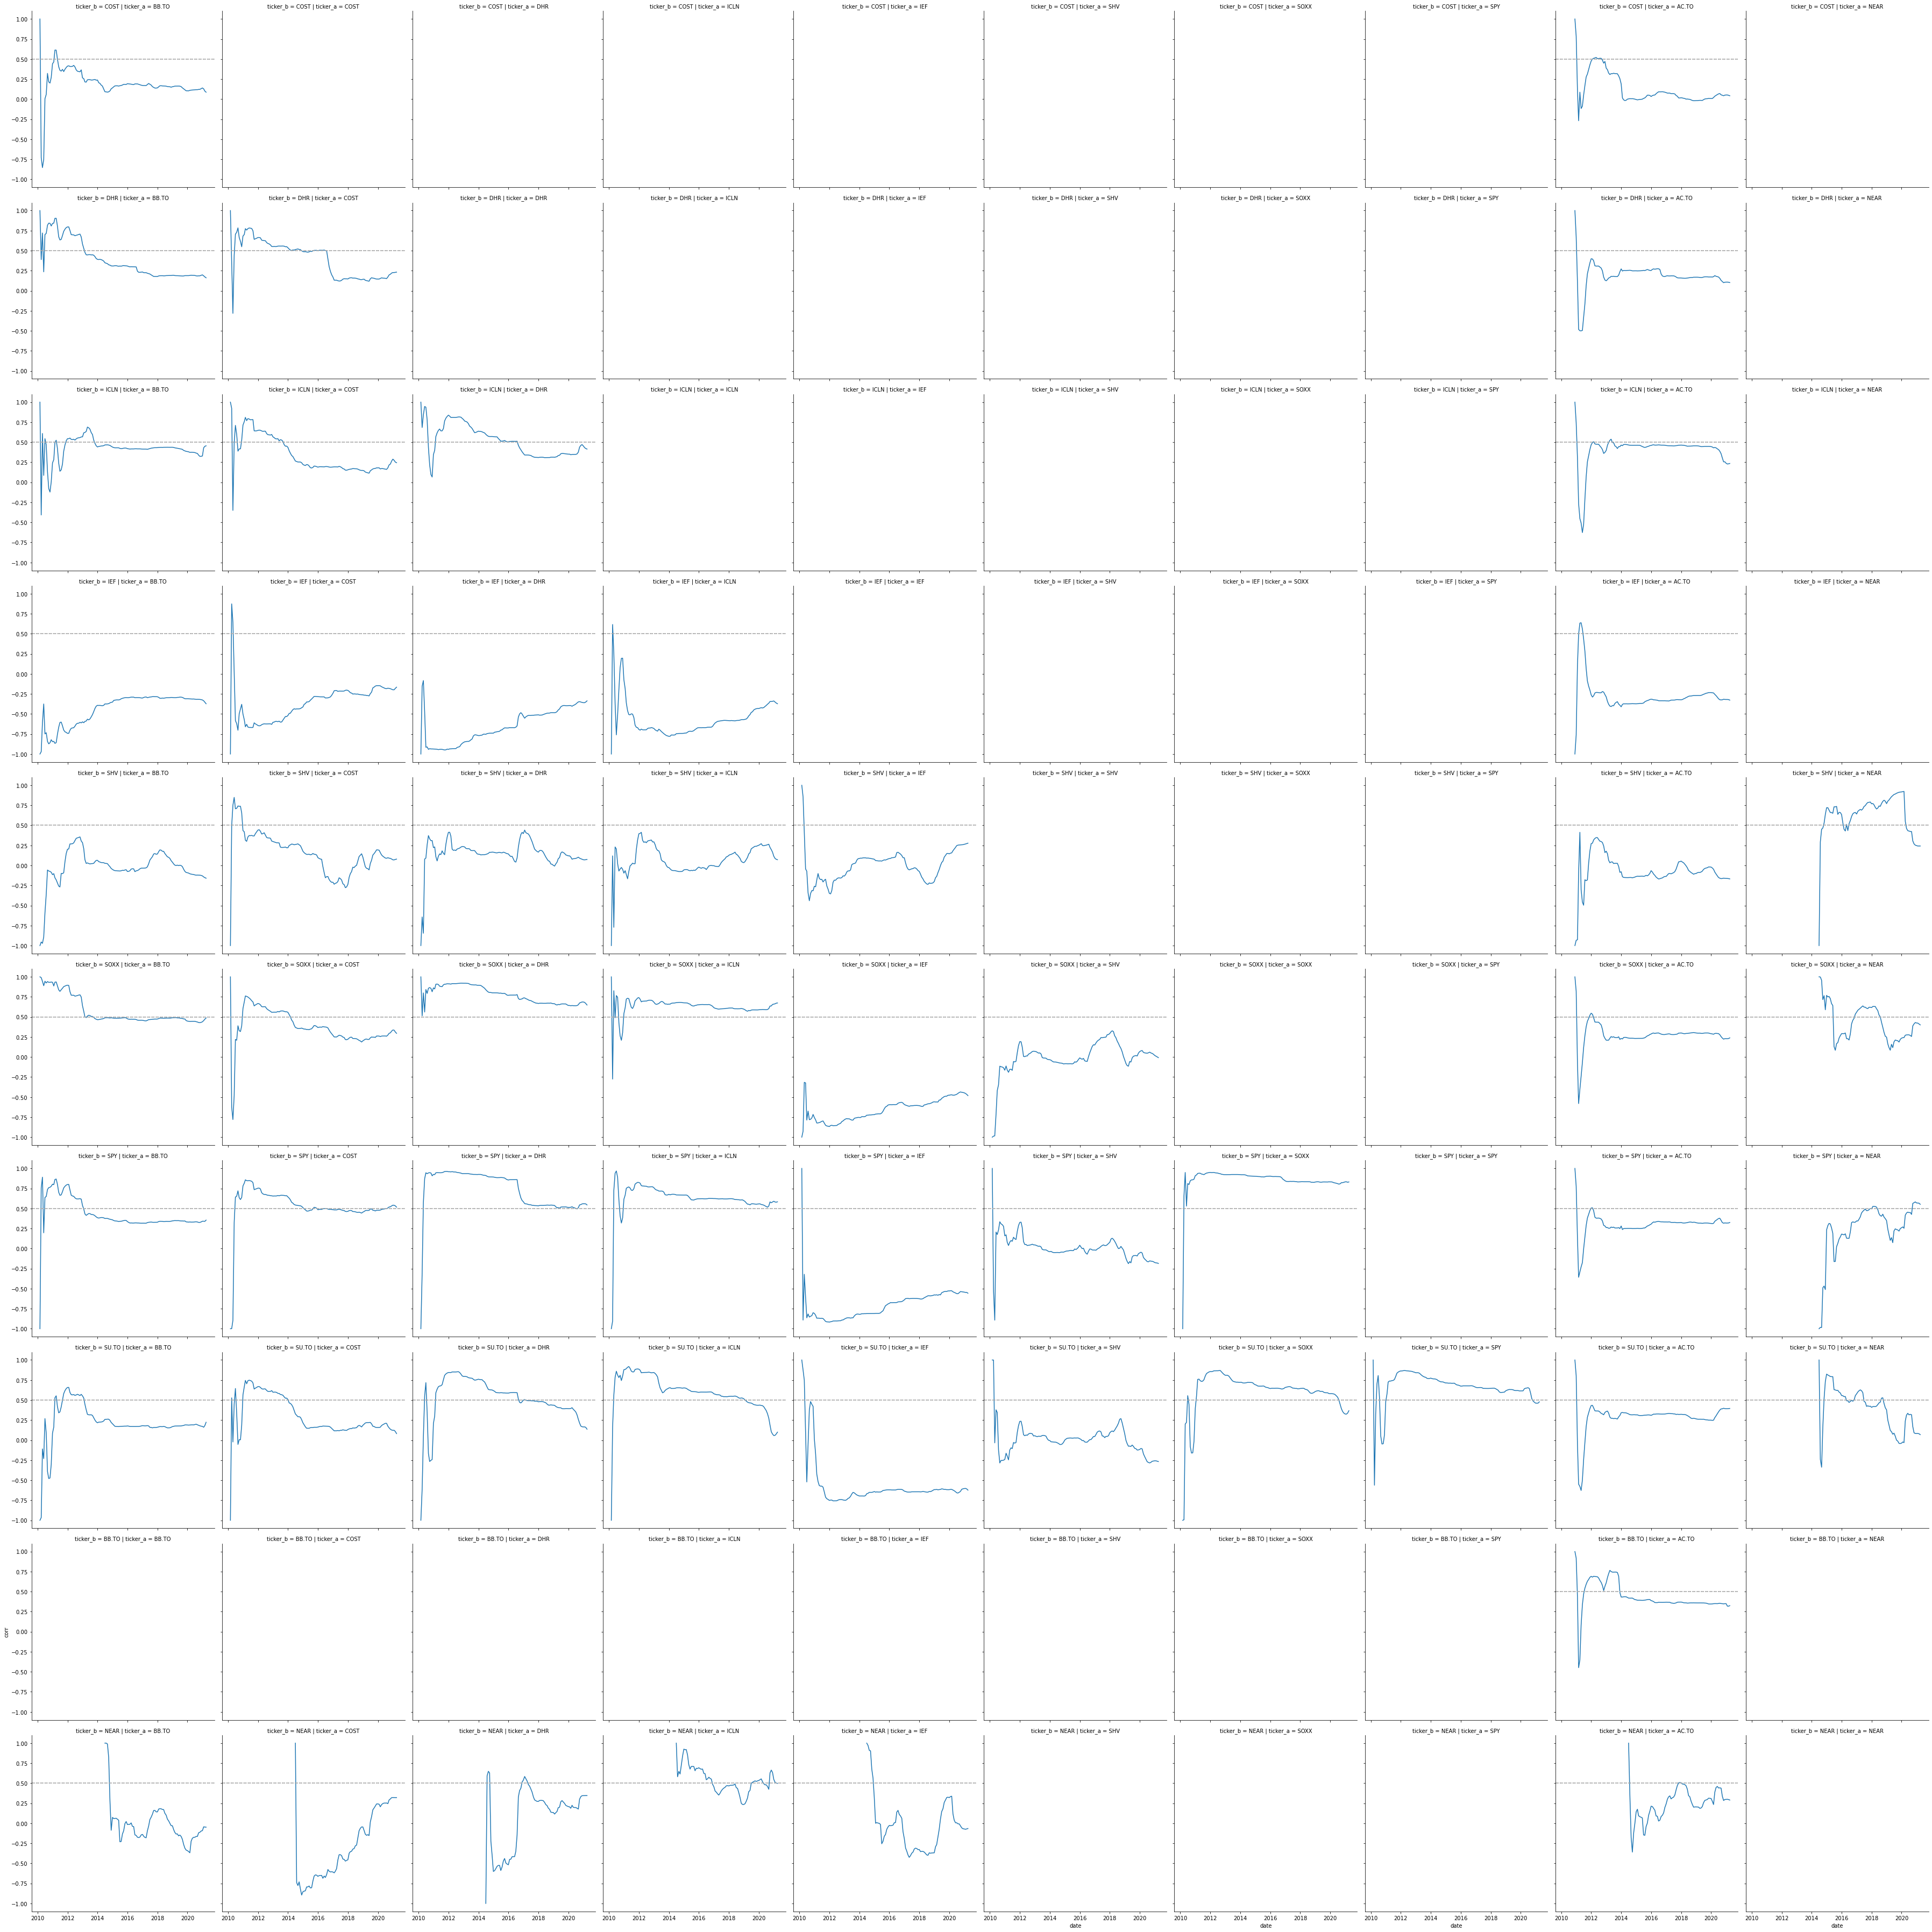

In [692]:
an.plot_corr_from_date(r6_df, '2010-01-01')